# Big Data and Data Mining Project
##  Road Traffic Accidents Analysis
Student ID: <202221654>                 
----
## Table of contents





- <a href="#Project-Introduction">Project Introduction</a>
- <a href="#Preliminary-Wrangling">Preliminary Wrangling</a>
- <a href="#Data-Exploration">Data Exploration</a>
- <a href="#Analysis">Analysis</a>
- <a href="#Temporal-Trends">Temporal Trends</a>
- <a href="#Temporal-Trends-Motorcycles">Temporal Trends Motorcycles</a>
- <a href="#Temporal-Trends-Pedestrain">Temporal Trends Pedestrain</a>
- <a href="#Association-Mining">Association Mining</a>
- <a href="#Assessment-Summary">Assessment Summary</a>
- <a href="#Data-Cleaning-using-stats-20">Data Cleaning using stats 20</a>
- <a href="#Clustering">Clustering</a>
- <a href="#Outlier-Detection">Outlier Detection</a>
- <a href="#Classification-Model">Classification Model</a>


# Project Introduction

This jupyter notebook analysis analyzes fatal road traffic accidents in Great Britain in 2020. The objective is to uncover accident patterns, identify factors impacting severity, and develop a model to predict fatalities. The aim is to assist the government in improving traffic safety policies and reducing accident-related fatality rates

## Preliminary Wrangling

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import sqlite3
import random
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

# clustering
import folium
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# association mining
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest,f_classif

# classification
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


# outlier 
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from numpy import quantile, where




In [2]:
# Establishing a connection to the SQLite database file 
con = sqlite3.connect("accident_data_v1.0.0_2023.db")

In [3]:
# Creating a cursor object to interact with the SQLite database connected through 'con'
cur = con.cursor()


# Data Exploration
### Accident table

In [4]:
# Retrieve column names from the accident table
query = "PRAGMA table_info(accident)"
cursor = con.execute(query)
column_accident = [column[1] for column in cursor.fetchall()]
print(column_accident)

['accident_index', 'accident_year', 'accident_reference', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'police_force', 'accident_severity', 'number_of_vehicles', 'number_of_casualties', 'date', 'day_of_week', 'time', 'local_authority_district', 'local_authority_ons_district', 'local_authority_highway', 'first_road_class', 'first_road_number', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'second_road_class', 'second_road_number', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident', 'trunk_road_flag', 'lsoa_of_accident_location']


### Vehicle table

In [5]:
# Retrieve column names from the vehicle table
query = "PRAGMA table_info(vehicle)"
cursor = con.execute(query)
column_vehicle = [column[1] for column in cursor.fetchall()]
print(column_vehicle)

['vehicle_index', 'accident_index', 'accident_year', 'accident_reference', 'vehicle_reference', 'vehicle_type', 'towing_and_articulation', 'vehicle_manoeuvre', 'vehicle_direction_from', 'vehicle_direction_to', 'vehicle_location_restricted_lane', 'junction_location', 'skidding_and_overturning', 'hit_object_in_carriageway', 'vehicle_leaving_carriageway', 'hit_object_off_carriageway', 'first_point_of_impact', 'vehicle_left_hand_drive', 'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver', 'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code', 'age_of_vehicle', 'generic_make_model', 'driver_imd_decile', 'driver_home_area_type']


### Casualty table

In [6]:
# Retrieve column names from the casualty table
query = "PRAGMA table_info(casualty)"
cursor = con.execute(query)
column_casualty = [column[1] for column in cursor.fetchall()]
print(column_casualty)

['casualty_index', 'accident_index', 'accident_year', 'accident_reference', 'vehicle_reference', 'casualty_reference', 'casualty_class', 'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty', 'casualty_severity', 'pedestrian_location', 'pedestrian_movement', 'car_passenger', 'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker', 'casualty_type', 'casualty_home_area_type', 'casualty_imd_decile']


### lsoa table

In [7]:
# Retrieve column names from the lsoa table
query = "PRAGMA table_info(lsoa)"
cursor = con.execute(query)
column_lsoa = [column[1] for column in cursor.fetchall()]
print(column_lsoa)

['objectid', 'lsoa01cd', 'lsoa01nm', 'lsoa01nmw', 'shape__area', 'shape__length', 'globalid']


# Analysis
## Temporal Trends
### Are there significant hours of the day, and days of the week, on which accidents occur?

In [8]:
#time and day from accident data
temporal_trends = pd.read_sql_query("""
    SELECT accident_index, time, day_of_week FROM accident WHERE accident.accident_year = 2020
""", con)

temporal_trends.head()

,accident_index,time,day_of_week
0,2020010219808,09:00,3
1,2020010220496,13:55,2
2,2020010228005,01:25,4
3,2020010228006,01:50,4
4,2020010228011,02:25,4


In [9]:
# check for null values
temporal_trends.isna().sum()

accident_index    0
time              0
day_of_week       0
dtype: int64

In [10]:
print(temporal_trends['time'].unique())
print(temporal_trends['day_of_week'].unique())

['09:00' '13:55' '01:25' ... '04:51' '05:11' '04:42']
[3 2 4 5 6 7 1]


In [11]:
# Extract the hour and day of the week from the 'Time' and 'Date' columns
#accident_df['converted_time'] = pd.DatetimeIndex(accident_df['time']) 
temporal_trends["hour"] = temporal_trends["time"].apply(lambda x: x[:2])

day_name = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Assuming you have a DataFrame called 'df' with your data and a column 'day_of_week'
# Convert day_of_week to day_name
temporal_trends['day_name'] = temporal_trends['day_of_week'].map(day_name)

In [12]:
# define a function that plots hour and day
def plot_hourly_and_daily_accidents(df):
  
    # Group the data by hour and count the number of accidents in each hour
    hourly_accidents = df.groupby('hour').size().reset_index(name='count')

    # Sort the DataFrame by the number of accidents in descending order
    hourly_accidents_sorted = hourly_accidents.sort_values(by='count', ascending=False)

    # Convert the sorted DataFrame to a dictionary
    hourly_accidents_dict = hourly_accidents_sorted.to_dict(orient='records')

    # Display the sorted values as a dictionary
    print(hourly_accidents_dict)
    
    # Sorting the DataFrame by hour
    df_sort_hour = df.sort_values("hour", ascending=True)

    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Plot for hourly accidents
    plt.subplot(1, 2, 1)
    sns.histplot(df_sort_hour["hour"], bins=24, edgecolor='black', alpha=0.8, kde=True)

    # Add labels and title
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Accidents')
    plt.title('Accidents by Hour of the Day')

    # Customize the x-axis ticks to show hours from 0 to 23
    plt.xticks(np.arange(24), rotation="vertical")

    # Plot for daily accidents
    plt.subplot(1, 2, 2)
    sns.countplot(data=df, x='day_name', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    # Add labels and title
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Accidents')
    plt.title('Accidents by Day of the Week')

    # Customize the x-axis ticks to show day names in order
    plt.xticks(rotation="vertical")

    # Save the figure as 'day_name.png'
    plt.savefig("day_name.png")

    # Show the plot
    plt.tight_layout()
    plt.show()

[{'hour': '17', 'count': 7813}, {'hour': '16', 'count': 7381}, {'hour': '15', 'count': 7361}, {'hour': '18', 'count': 6618}, {'hour': '14', 'count': 6245}, {'hour': '13', 'count': 5741}, {'hour': '12', 'count': 5395}, {'hour': '08', 'count': 5267}, {'hour': '19', 'count': 5048}, {'hour': '11', 'count': 4812}, {'hour': '10', 'count': 4173}, {'hour': '09', 'count': 3917}, {'hour': '07', 'count': 3736}, {'hour': '20', 'count': 3715}, {'hour': '21', 'count': 3106}, {'hour': '22', 'count': 2555}, {'hour': '06', 'count': 1830}, {'hour': '23', 'count': 1796}, {'hour': '00', 'count': 1188}, {'hour': '01', 'count': 915}, {'hour': '05', 'count': 855}, {'hour': '02', 'count': 658}, {'hour': '03', 'count': 566}, {'hour': '04', 'count': 508}]


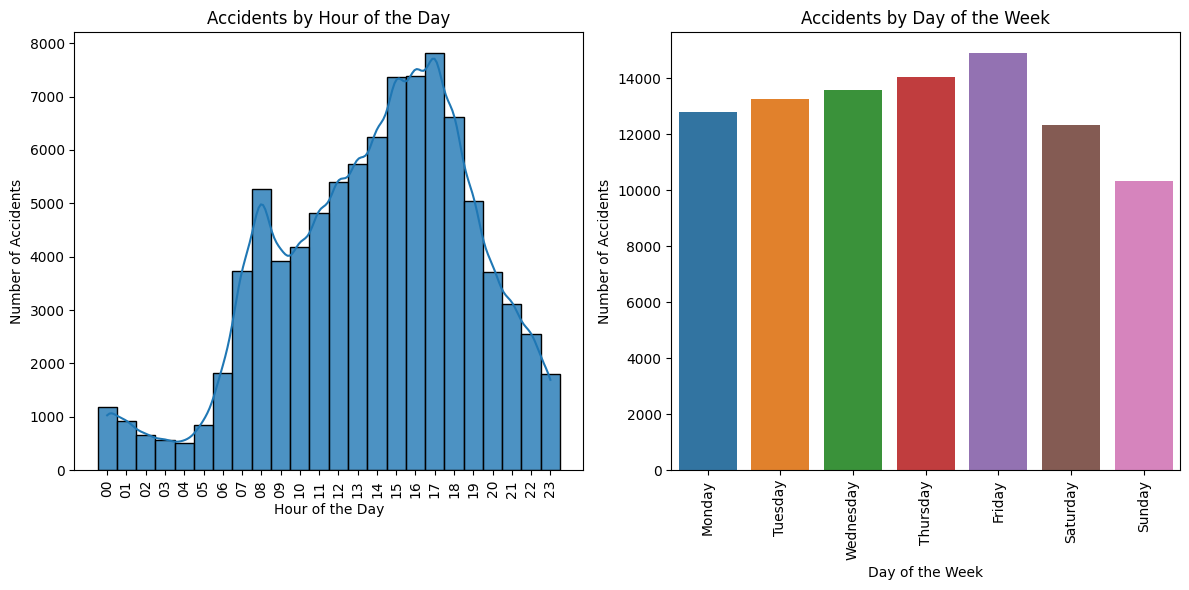

In [13]:
plot_hourly_and_daily_accidents(temporal_trends)

## Temporal Trends Motorcycles
### For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? We suggest a focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.

In [14]:
# time and day for motorcycles
temporal_trends_motorcycles = pd.read_sql_query("""
    SELECT  a.accident_index, a.time, a.day_of_week,v.vehicle_type 
    FROM accident a
    INNER JOIN vehicle v
    ON a.accident_index = v.accident_index 
    WHERE v.vehicle_type IN (2, 3, 4, 5) AND a.accident_year = 2020 
 """, con)

temporal_trends_motorcycles.head()

,accident_index,time,day_of_week,vehicle_type
0,2020010228020,03:25,4,3
1,2020010228077,08:00,4,2
2,2020010228086,14:00,4,3
3,2020010228097,14:37,4,3
4,2020010228148,19:05,4,3


In [15]:
temporal_trends_motorcycles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14126 entries, 0 to 14125
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   accident_index  14126 non-null  object
 1   time            14126 non-null  object
 2   day_of_week     14126 non-null  int64 
 3   vehicle_type    14126 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 441.6+ KB


In [16]:
# Filter accidents based on vehicle type Motorcycle_under_50cc
Mcycle_under_50cc = temporal_trends_motorcycles[temporal_trends_motorcycles['vehicle_type'] == 2]

# Filter accidents based on vehicle type Motorcycle_over_50cc_and_up_to_125cc
Mcycle_over_50cc_and_up_to_125cc =  temporal_trends_motorcycles[temporal_trends_motorcycles['vehicle_type'] == 3]

# Filter accidents based on vehicle type Motorcycle_125cc_and_under
# Concatenate multiple tables along columns (horizontally)
Mcycle_125cc_and_under = pd.concat([Mcycle_under_50cc, Mcycle_over_50cc_and_up_to_125cc]) 

# Filter accidents based on vehicle type Motorcycle_over_125cc_and_up_to_500cc
Mcycle_over_125cc_to_500cc =  temporal_trends_motorcycles[temporal_trends_motorcycles['vehicle_type'] == 4]

# Filter accidents based on vehicle type Motorcycle_over_500cc
Mcycle_over_500cc =  temporal_trends_motorcycles[temporal_trends_motorcycles['vehicle_type'] == 5]



In [17]:
# Extract the hour and day of the week from the 'Time' and 'Date' columns
#accident_df['converted_time'] = pd.DatetimeIndex(accident_df['time']) 
Mcycle_125cc_and_under["hour"] = Mcycle_125cc_and_under["time"].apply(lambda x: x[:2])
# Sort the data by the hour column in ascending order
Mcycle_125cc_and_under_sorted = Mcycle_125cc_and_under.sort_values(by='hour')

#Mcycle_over_125cc_to_500cc["hour"] = Mcycle_125cc_and_under["time"].apply(lambda x: x[:2])
Mcycle_over_125cc_to_500cc["hour"] = Mcycle_over_125cc_to_500cc["time"].apply(lambda x: int(x[:2]))
# Sort the data by the hour column in ascending order
Mcycle_over_125cc_to_500cc_sorted = Mcycle_over_125cc_to_500cc.sort_values(by='hour')

#Mcycle_over_500cc["hour"] = Mcycle_125cc_and_under["time"].apply(lambda x: x[:2])
Mcycle_over_500cc["hour"] = Mcycle_over_500cc["time"].apply(lambda x: int(x[:2]))
# Sort the data by the hour column in ascending order
Mcycle_over_500cc_sorted = Mcycle_over_500cc.sort_values(by='hour')

C:\Users\chime\AppData\Local\Temp\ipykernel_19632\1832517938.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mcycle_over_125cc_to_500cc["hour"] = Mcycle_over_125cc_to_500cc["time"].apply(lambda x: int(x[:2]))
C:\Users\chime\AppData\Local\Temp\ipykernel_19632\1832517938.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mcycle_over_500cc["hour"] = Mcycle_over_500cc["time"].apply(lambda x: int(x[:2]))


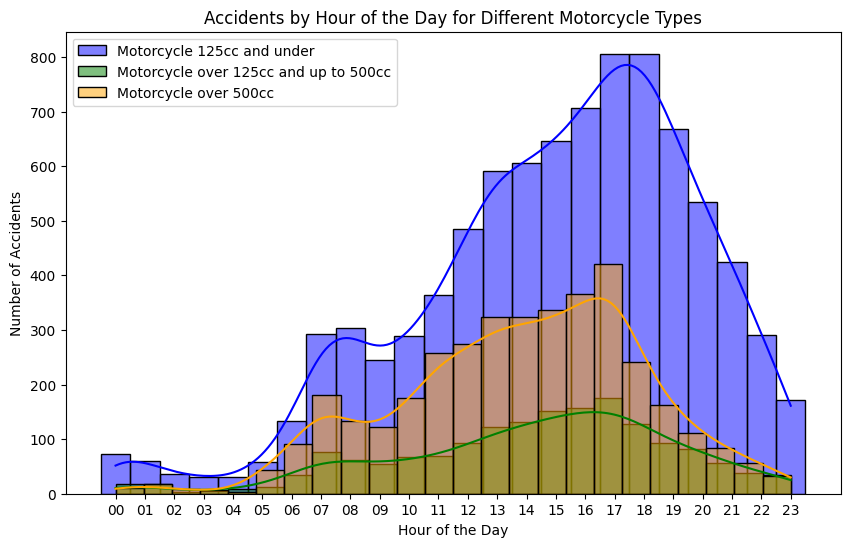

In [18]:
# Plot the histograms with sorted data
plt.figure(figsize=(10, 6))

sns.histplot(data=Mcycle_125cc_and_under_sorted, x='hour', bins=24, kde=True, color='blue', label='Motorcycle 125cc and under')
sns.histplot(data=Mcycle_over_125cc_to_500cc_sorted, x='hour', bins=24, kde=True, color='green', label='Motorcycle over 125cc and up to 500cc')
sns.histplot(data=Mcycle_over_500cc_sorted, x='hour', bins=24, kde=True, color='orange', label='Motorcycle over 500cc')

plt.title("Accidents by Hour of the Day for Different Motorcycle Types")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Accidents")
plt.xticks(range(24))
plt.legend()
plt.show()

In [19]:
day_name = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Assuming you have a DataFrame called 'df' with your data and a column 'day_of_week'
# Convert day_of_week to day_name
Mcycle_125cc_and_under['day_name'] = Mcycle_125cc_and_under['day_of_week'].map(day_name)

Mcycle_over_125cc_to_500cc['day_name'] = Mcycle_over_125cc_to_500cc['day_of_week'].map(day_name)

Mcycle_over_500cc['day_name'] = Mcycle_over_500cc['day_of_week'].map(day_name)


C:\Users\chime\AppData\Local\Temp\ipykernel_19632\1969517661.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mcycle_over_125cc_to_500cc['day_name'] = Mcycle_over_125cc_to_500cc['day_of_week'].map(day_name)
C:\Users\chime\AppData\Local\Temp\ipykernel_19632\1969517661.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Mcycle_over_500cc['day_name'] = Mcycle_over_500cc['day_of_week'].map(day_name)


In [20]:
Mcycle_over_500cc['day_name'].value_counts()

Sunday       675
Friday       567
Saturday     550
Thursday     526
Wednesday    501
Tuesday      497
Monday       468
Name: day_name, dtype: int64

In [21]:
Mcycle_over_125cc_to_500cc['day_name'].value_counts()

Friday       267
Thursday     257
Wednesday    251
Saturday     237
Tuesday      234
Monday       227
Sunday       218
Name: day_name, dtype: int64

In [22]:
Mcycle_125cc_and_under['day_name'].value_counts()

Friday       1474
Thursday     1389
Wednesday    1249
Saturday     1216
Tuesday      1202
Monday       1173
Sunday        948
Name: day_name, dtype: int64

<Figure size 1200x800 with 0 Axes>

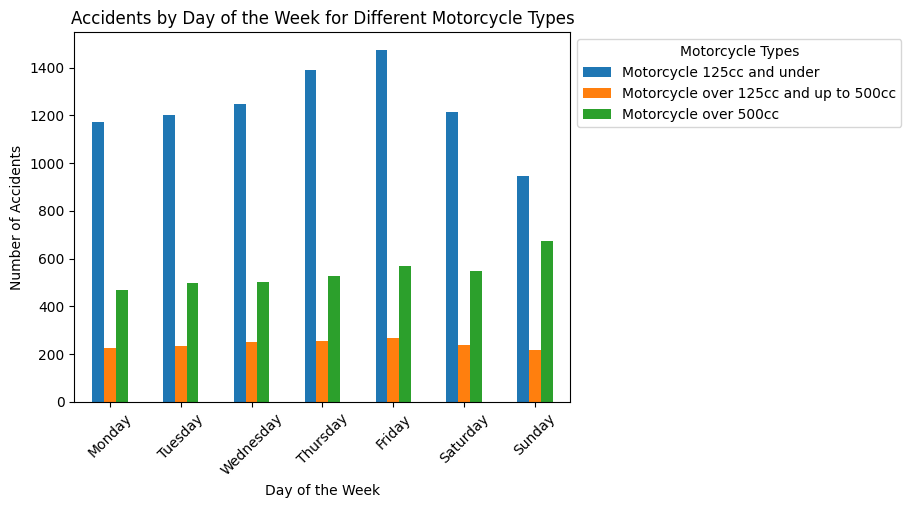

In [23]:
# Count the number of accidents for each day of the week and motorcycle category
accidents_by_day = {
    'Motorcycle 125cc and under': Mcycle_125cc_and_under['day_name'].value_counts(),
    'Motorcycle over 125cc and up to 500cc': Mcycle_over_125cc_to_500cc['day_name'].value_counts(),
    'Motorcycle over 500cc': Mcycle_over_500cc['day_name'].value_counts()
}

# Convert the dictionary into a DataFrame
accidents_by_day_df = pd.DataFrame(accidents_by_day)

# Sort the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
accidents_by_day_df = accidents_by_day_df.reindex(day_order)

# Increase figure size
plt.figure(figsize=(12, 8))

# Plotting
ax = accidents_by_day_df.plot(kind='bar', stacked=False)
plt.title("Accidents by Day of the Week for Different Motorcycle Types")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45)
# Move the legend to the upper left corner outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Motorcycle Types")

plt.show()


## Temporal Trends Pedestrians
### For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

In [24]:
#time and day for pedestrians
temporal_trends_pedestrian = pd.read_sql_query("""
    SELECT  a.accident_index, a.time, a.day_of_week,c.casualty_class 
    FROM accident a
    INNER JOIN casualty c
    ON a.accident_index = c.accident_index 
    WHERE c.casualty_class IN (3) AND a.accident_year = 2020 
 """, con)

temporal_trends_pedestrian.head()

,accident_index,time,day_of_week,casualty_class
0,2020010219808,09:00,3,3
1,2020010220496,13:55,2,3
2,2020010220496,13:55,2,3
3,2020010228005,01:25,4,3
4,2020010228006,01:50,4,3


In [25]:
temporal_trends_pedestrian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14750 entries, 0 to 14749
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   accident_index  14750 non-null  object
 1   time            14750 non-null  object
 2   day_of_week     14750 non-null  int64 
 3   casualty_class  14750 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 461.1+ KB


[{'hour': '15', 'count': 1672}, {'hour': '16', 'count': 1323}, {'hour': '17', 'count': 1274}, {'hour': '18', 'count': 1146}, {'hour': '08', 'count': 1060}, {'hour': '14', 'count': 1015}, {'hour': '13', 'count': 833}, {'hour': '19', 'count': 824}, {'hour': '12', 'count': 809}, {'hour': '11', 'count': 725}, {'hour': '10', 'count': 644}, {'hour': '09', 'count': 607}, {'hour': '20', 'count': 518}, {'hour': '07', 'count': 514}, {'hour': '21', 'count': 412}, {'hour': '22', 'count': 365}, {'hour': '23', 'count': 230}, {'hour': '06', 'count': 173}, {'hour': '00', 'count': 173}, {'hour': '01', 'count': 144}, {'hour': '02', 'count': 83}, {'hour': '03', 'count': 82}, {'hour': '05', 'count': 74}, {'hour': '04', 'count': 50}]


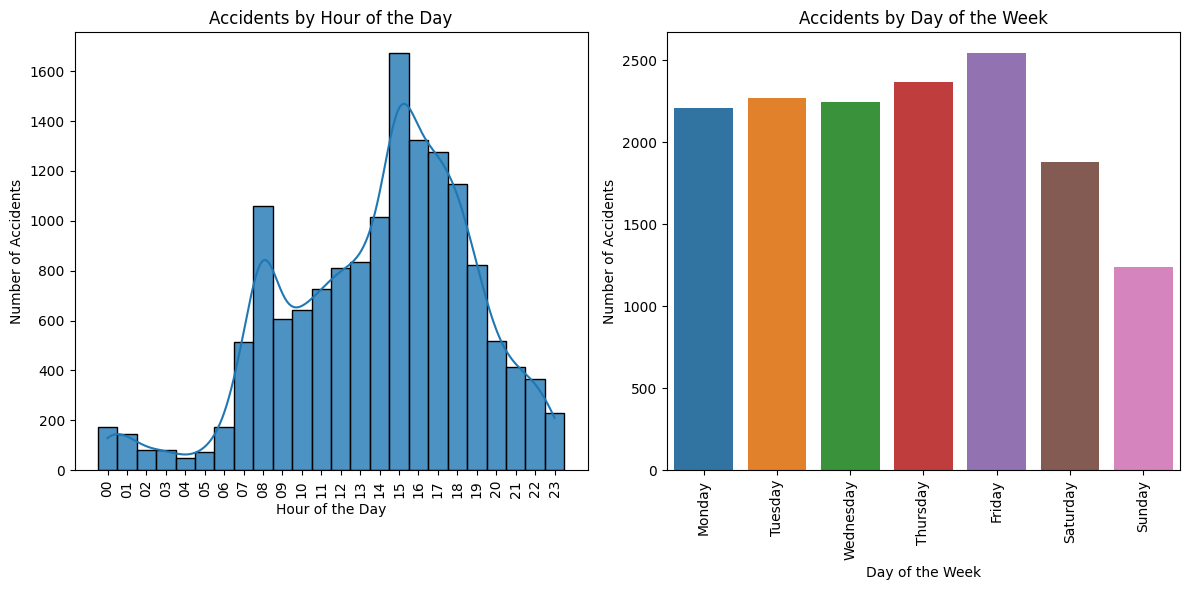

In [26]:
# Extract the hour and day of the week from the 'Time' and 'Date' columns
#accident_df['converted_time'] = pd.DatetimeIndex(accident_df['time']) 
temporal_trends_pedestrian["hour"] = temporal_trends_pedestrian["time"].apply(lambda x: x[:2])

day_name = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}

# Assuming you have a DataFrame called 'df' with your data and a column 'day_of_week'
# Convert day_of_week to day_name
temporal_trends_pedestrian['day_name'] = temporal_trends_pedestrian['day_of_week'].map(day_name)


plot_hourly_and_daily_accidents(temporal_trends_pedestrian)

## Association Mining
### Using the apriori algorithm, explore the impact of selected variables on accident severity.  
Eboli, L., Forciniti, C. & Mazzulla, G. (2020) Factors influencing accident severity: an analysis by road accident type. Transportation Research Procedia, 47, 449–456. Available online: https://doi.org/10.1016/j.trpro.2020.03.120.

- speed_limit
- weather_conditions
- light_conditions
- road_type
- road_surface_conditions
- urban_or_rural_area
- vehicle_type
- sex_of_driver
- age_of_driver
- age_band_of_driver
- pedestrian_movement
- casualty_class

In [27]:
#Eboli, L., Forciniti, C. & Mazzulla, G. (2020) Factors influencing accident severity: an analysis by road accident type. Transportation Research Procedia, 47, 449–456. Available online: https://doi.org/10.1016/j.trpro.2020.03.120.

a_mining = pd.read_sql_query("""
    SELECT  a.accident_severity,a.speed_limit, a.weather_conditions, 
    a.light_conditions, a.road_type, a.road_surface_conditions, a.urban_or_rural_area,
    v.vehicle_type, v.sex_of_driver, v.age_of_driver, v.age_band_of_driver, c.pedestrian_movement, c.casualty_class
    FROM accident a
    INNER JOIN vehicle v
    ON a.accident_index = v.accident_index 
    INNER JOIN casualty c
    ON a.accident_index = c.accident_index
    WHERE a.accident_year = 2020 
 """, con)

a_mining.head()

,accident_severity,speed_limit,weather_conditions,light_conditions,road_type,road_surface_conditions,urban_or_rural_area,vehicle_type,sex_of_driver,age_of_driver,age_band_of_driver,pedestrian_movement,casualty_class
0,3,20,9,1,6,9,1,9,2,32,6,5,3
1,3,20,1,1,6,1,1,9,1,45,7,1,3
2,3,20,1,1,6,1,1,9,1,45,7,1,3
3,3,30,1,4,6,2,1,9,3,-1,-1,9,3
4,2,30,1,4,6,1,1,8,1,44,7,1,3


In [28]:
a_mining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220435 entries, 0 to 220434
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   accident_severity        220435 non-null  int64
 1   speed_limit              220435 non-null  int64
 2   weather_conditions       220435 non-null  int64
 3   light_conditions         220435 non-null  int64
 4   road_type                220435 non-null  int64
 5   road_surface_conditions  220435 non-null  int64
 6   urban_or_rural_area      220435 non-null  int64
 7   vehicle_type             220435 non-null  int64
 8   sex_of_driver            220435 non-null  int64
 9   age_of_driver            220435 non-null  int64
 10  age_band_of_driver       220435 non-null  int64
 11  pedestrian_movement      220435 non-null  int64
 12  casualty_class           220435 non-null  int64
dtypes: int64(13)
memory usage: 21.9 MB


In [29]:
# Check for duplicates
a_mining.duplicated().sum()

137125

In [30]:
for column in a_mining:
    unique_values = a_mining[column].unique()
    print(f"Column '{column}' unique values: {unique_values}")

Column 'accident_severity' unique values: [3 2 1]
Column 'speed_limit' unique values: [20 30 40 50 60 70 -1]
Column 'weather_conditions' unique values: [ 9  1  8  7  2  4  5  3  6 -1]
Column 'light_conditions' unique values: [ 1  4  5  7  6 -1]
Column 'road_type' unique values: [6 2 3 7 1 9]
Column 'road_surface_conditions' unique values: [ 9  1  2  5  4  3 -1]
Column 'urban_or_rural_area' unique values: [1 2 3]
Column 'vehicle_type' unique values: [ 9  8  3  2 11  1 90 19  4  5 21 97 20 98 10 17 23 22 18 16]
Column 'sex_of_driver' unique values: [ 2  1  3 -1]
Column 'age_of_driver' unique values: [ 32  45  -1  44  20  25  41  19  26  62  37  40  33  51  30  18  29  24
  38  77  48  50  79  42  52  22  31  28  57  81  59  67  34  23  54  53
  27  39  56  43  88  35  46  16  49  21  80  66  55  47  60  36  58  70
  71  17  85  69  61  87  73  64  65  63  83  78  72  68  14  82  74  75
  11  76  15  86  90   9  10  91  84  13   8  89  93  94  92   6  12   5
   4   7  97  95   3  98 100  

## Assessment Summary
- duplicate values
- -1 values in speed_limit, junction_control, junction_detail, weather_conditions, light_conditions, road_surface_conditions, sex_of_driver, age_of_driver, age_band_of_driver, junction_location, pedestrian_movement, pedestrian_location
- incorrect values i based on stats 19 and 20 guides

## Data Cleaning

In [31]:
# create a copy
a_mining_copy = a_mining.copy(deep = True)

In [32]:
# drop duplicates
a_mining_copy.drop_duplicates(inplace=True)

# Check for duplicates
a_mining_copy.duplicated().sum()

0

In [33]:
a_mining_copy.shape

(83310, 13)

### Data Cleaning using stats 20

In [34]:
column_values = {
    'light_conditions': [1,4,5,6,7],
    'weather_conditions': [i for i in [1,2,3,4,5,6,7,8,9,10]],
    'road_surface_conditions':[1,2,3,4,5],
    'sex_of_driver': [i for i in [1,2,3]],
    'pedestrian_movement' : [i for i in [0,1,2,3,4,5,6,7,8,9]]
}


# Apply the dictionary using lambda function and replace()
for column, mapping in column_values.items():
    a_mining_copy[column] = a_mining_copy[column].apply(lambda x: x if x in mapping else -1)
    
counts_sorted = a_mining_copy.isin([-1]).sum().loc[lambda x: x > 0].sort_values(ascending=False)
print(counts_sorted) 


age_of_driver              6422
age_band_of_driver         6422
road_surface_conditions    1810
speed_limit                  14
sex_of_driver                12
pedestrian_movement           2
weather_conditions            1
light_conditions              1
dtype: int64


### Define a function that replaces -1 with mode

In [35]:
def replace_with_mode(df, column_name, value_to_replace):
    mode_value = df[column_name].mode().iloc[0]
    df[column_name] = df[column_name].replace(value_to_replace, mode_value)

### Define a function that replaces -1 with random

In [36]:
def replace_with_random(df, column_name, value_to_replace, seed =None):
    np.random.seed(seed)
    non_negative_values = df[df[column_name] != value_to_replace][column_name]
    replacement_values = np.random.choice(non_negative_values, size=(df[column_name] == value_to_replace).sum())
    
    df.loc[df[column_name] == value_to_replace, column_name] = replacement_values

### Treating speed_limit

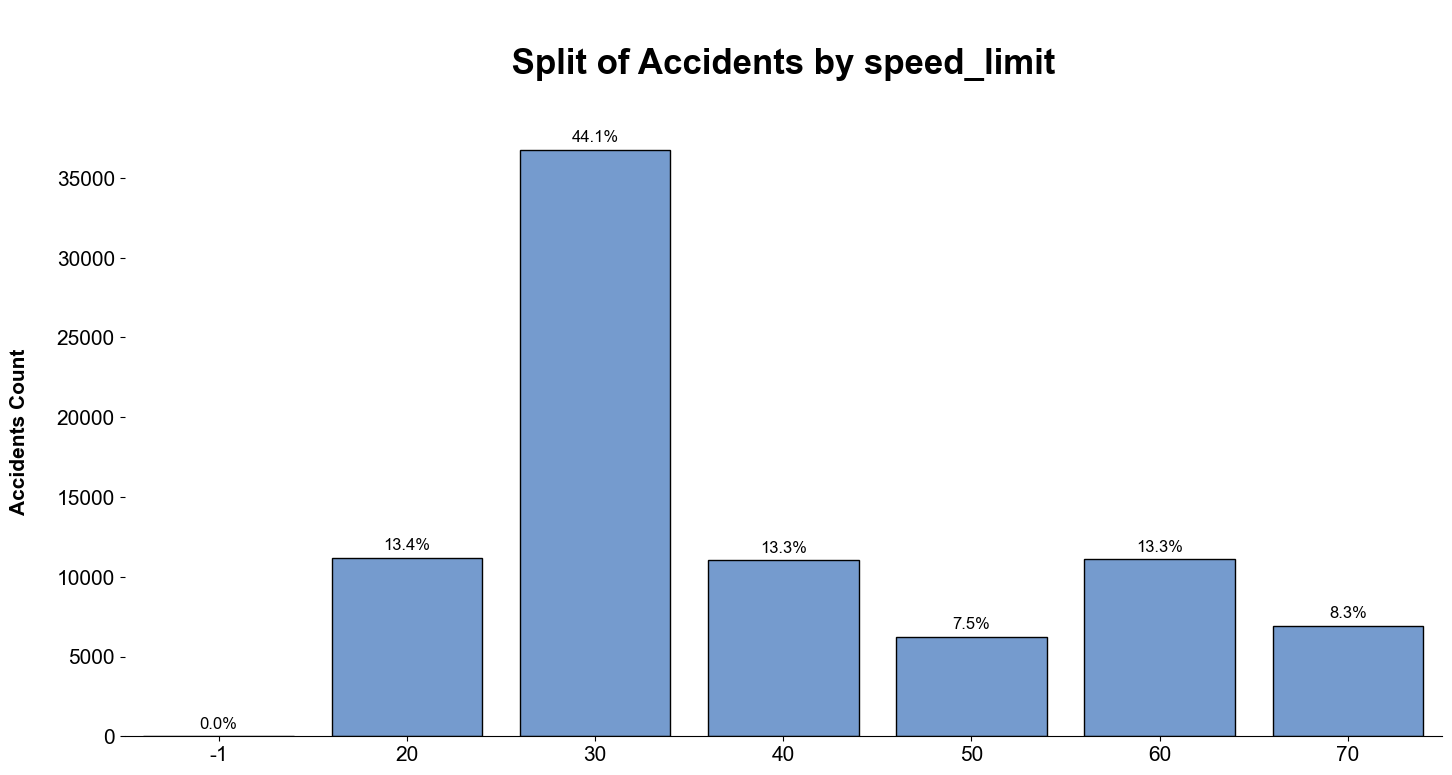

In [37]:
#group accidents by day of the speedlimit
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'speed_limit', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by speed_limit \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

In [38]:
# replace with mode
replace_with_mode(a_mining_copy, "speed_limit", -1)

print(a_mining_copy.speed_limit.isin([-1]).sum())

0


### Treating sex_of_driver

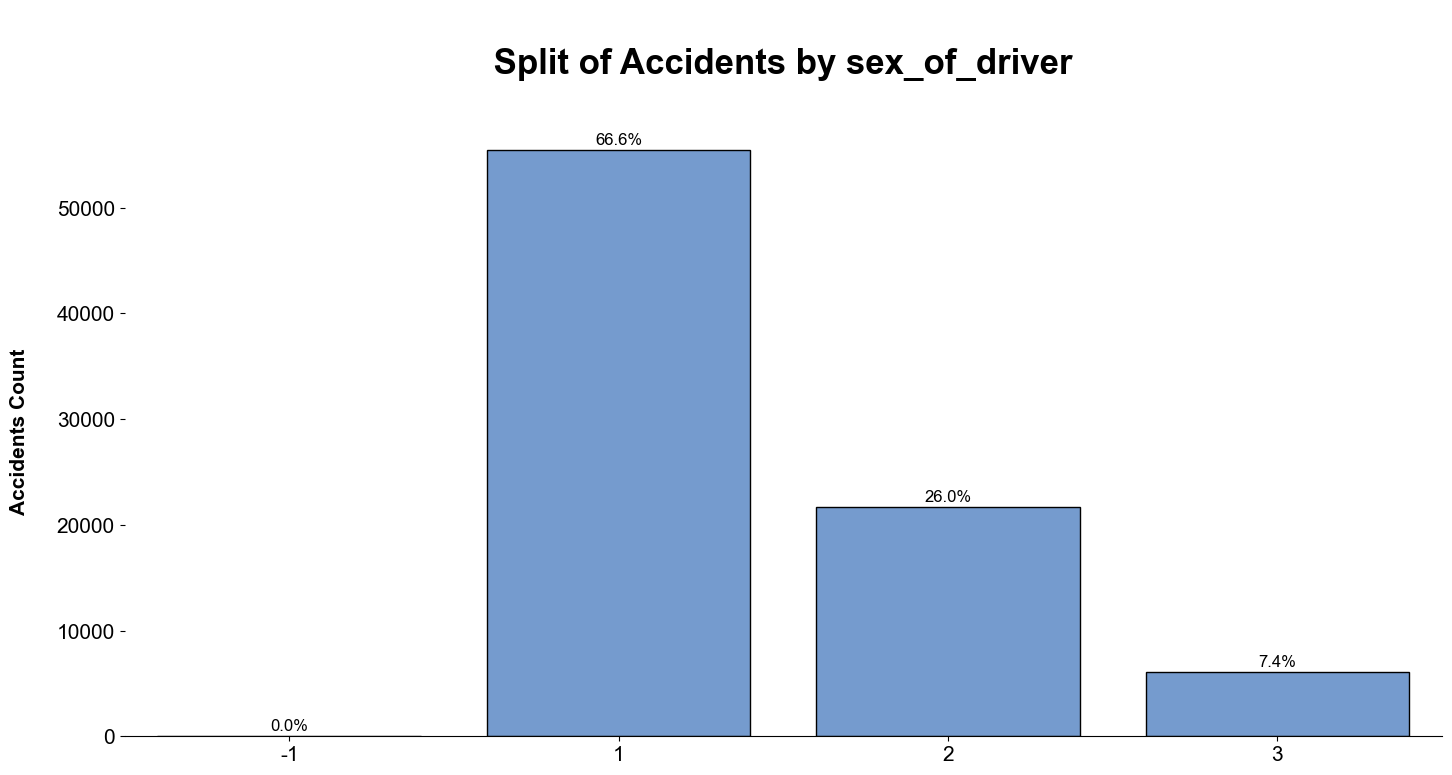

In [39]:
#group accidents by day of the sex_of_driver
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'sex_of_driver', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by sex_of_driver \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

In [40]:
# replace with mode
replace_with_mode(a_mining_copy, "sex_of_driver", -1)

print(a_mining_copy.sex_of_driver.isin([-1]).sum())

0


### Treating pedestrian_movement

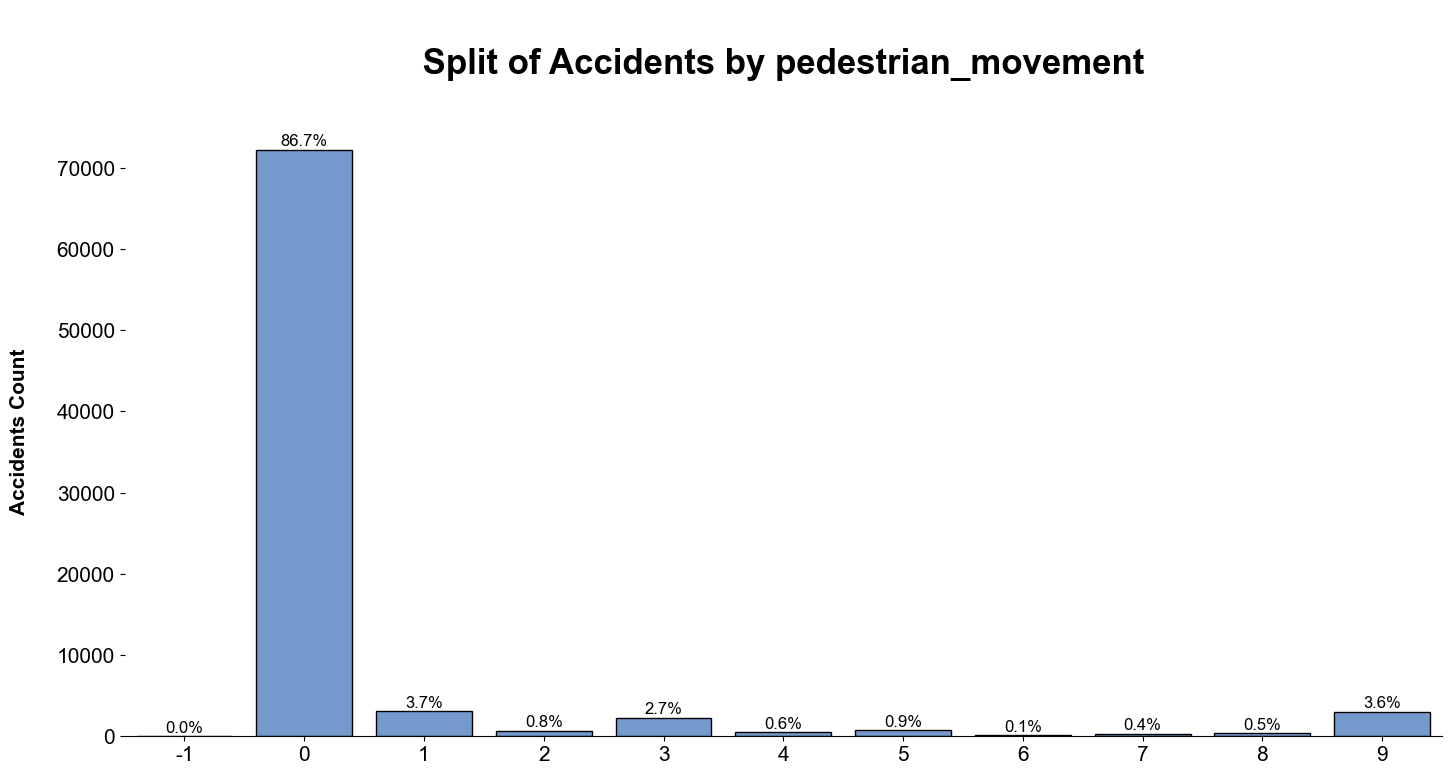

In [41]:
#group accidents by day of the pedestrian_movement
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'pedestrian_movement', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by pedestrian_movement \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

In [42]:
# replace with mode
replace_with_mode(a_mining_copy, "pedestrian_movement", -1)

print(a_mining_copy.pedestrian_movement.isin([-1]).sum())

0


### Treating weather_conditions

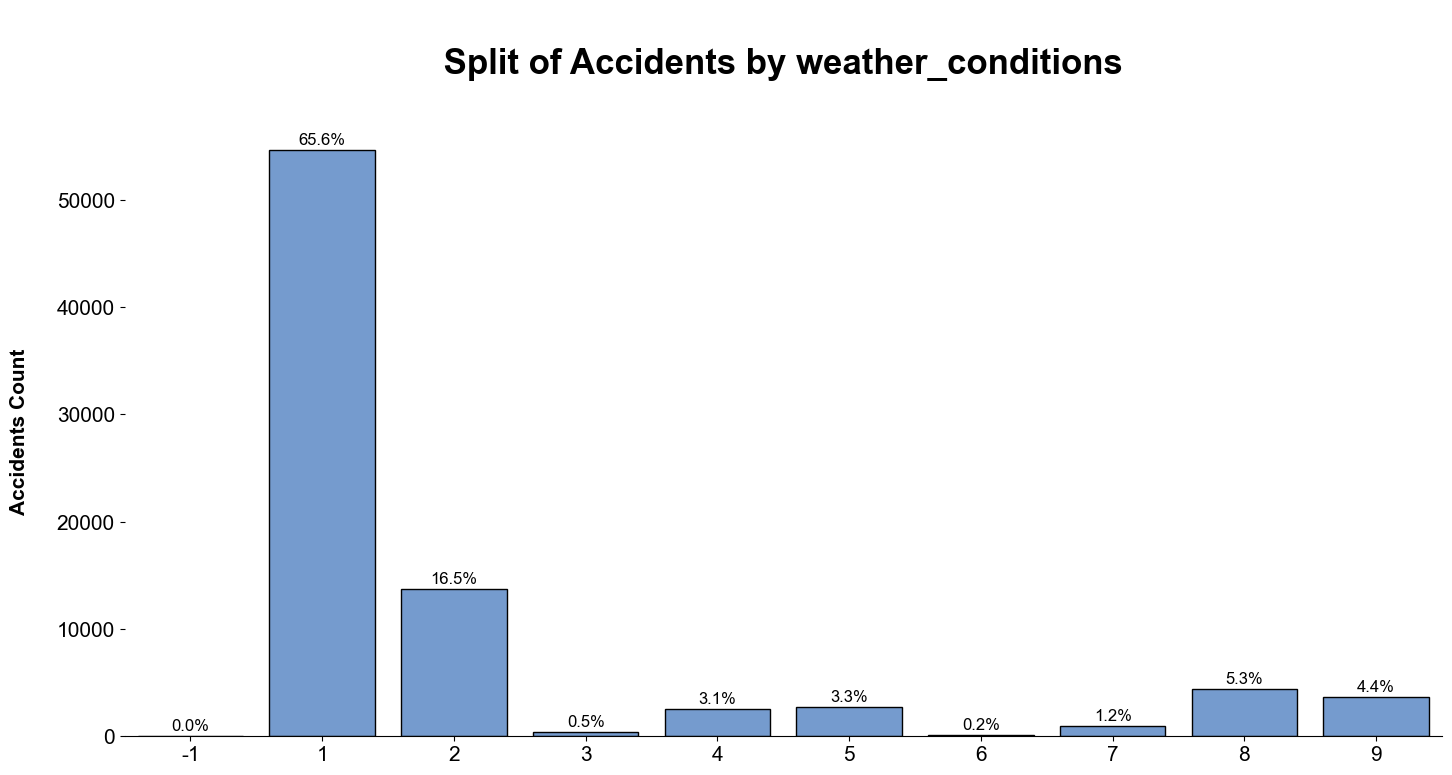

In [43]:
#group accidents by day of the weather_conditions
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'weather_conditions', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by weather_conditions \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

In [44]:
# replace with mode
replace_with_mode(a_mining_copy, "weather_conditions", -1)

print(a_mining_copy.weather_conditions.isin([-1]).sum())

0


### Treating light_conditions

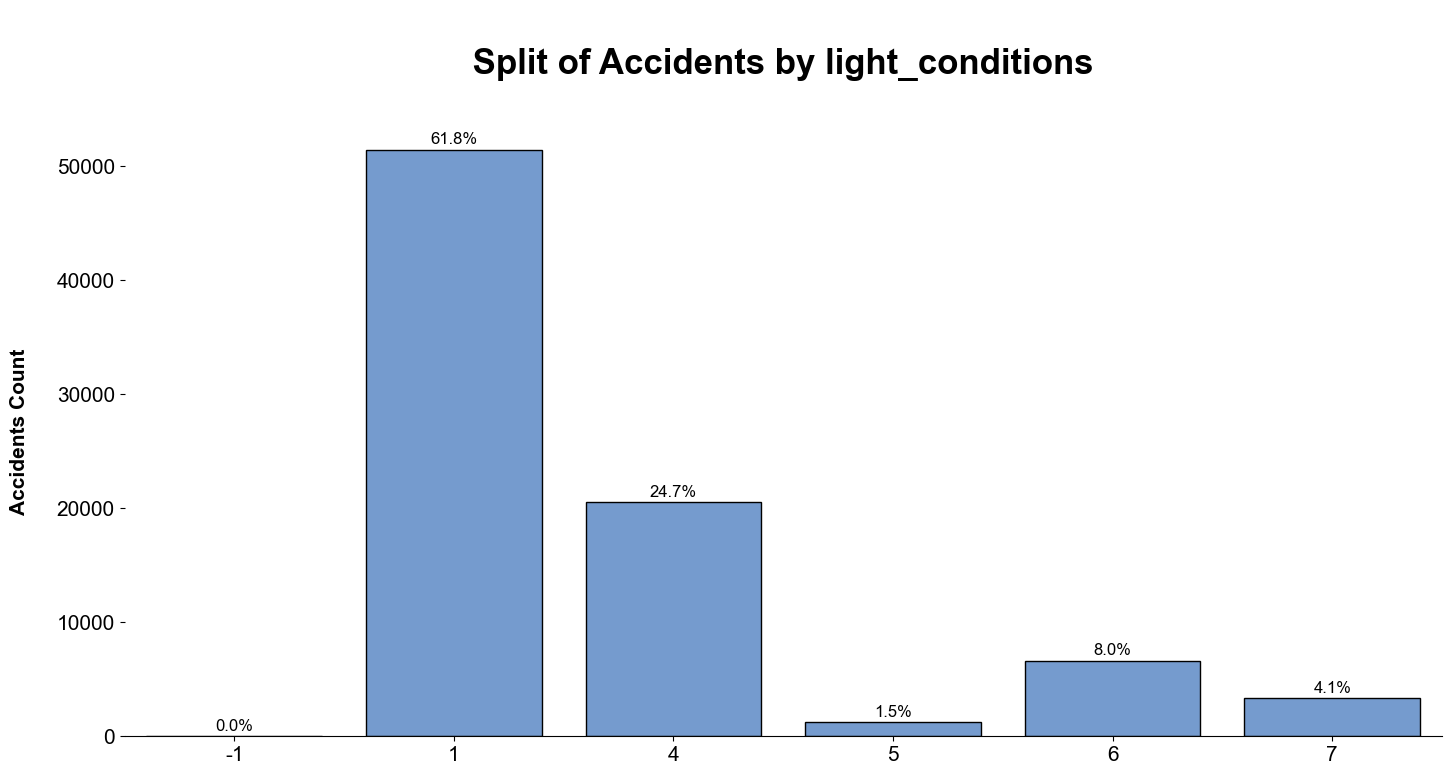

In [45]:
#group accidents by day of the light_conditions
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'light_conditions', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by light_conditions \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

In [46]:
# replace with mode
replace_with_mode(a_mining_copy, "light_conditions", -1)

print(a_mining_copy.light_conditions.isin([-1]).sum())

0


### Treating road_surface_conditions

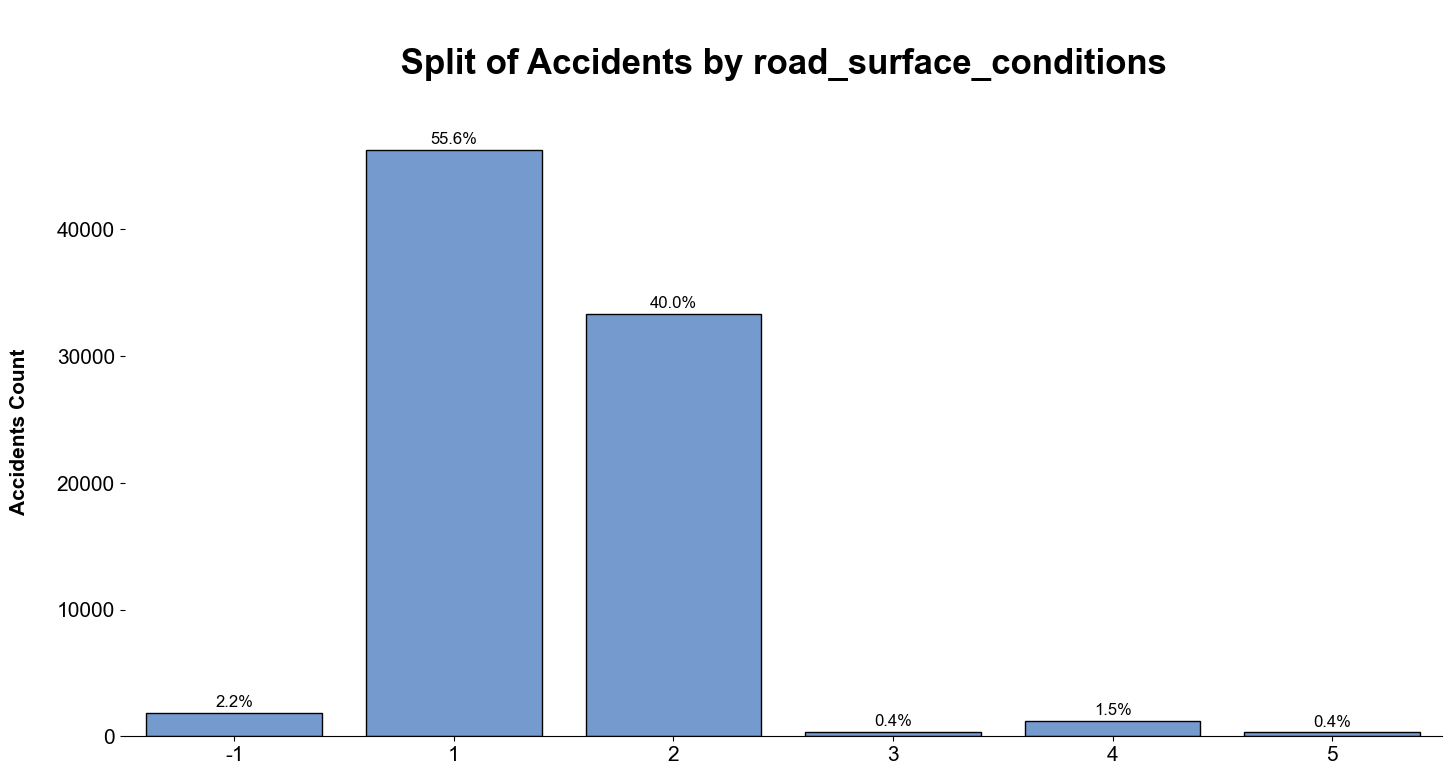

In [47]:
#group accidents by day of the speedlimit
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'road_surface_conditions', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by road_surface_conditions \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

In [48]:
# Replace -1 values with random values from the same column using the function
replace_with_random(a_mining_copy, 'road_surface_conditions', -1 , seed = 42)

print(a_mining_copy.road_surface_conditions.isin([-1]).sum())

0


### Treating Age Band of Driver

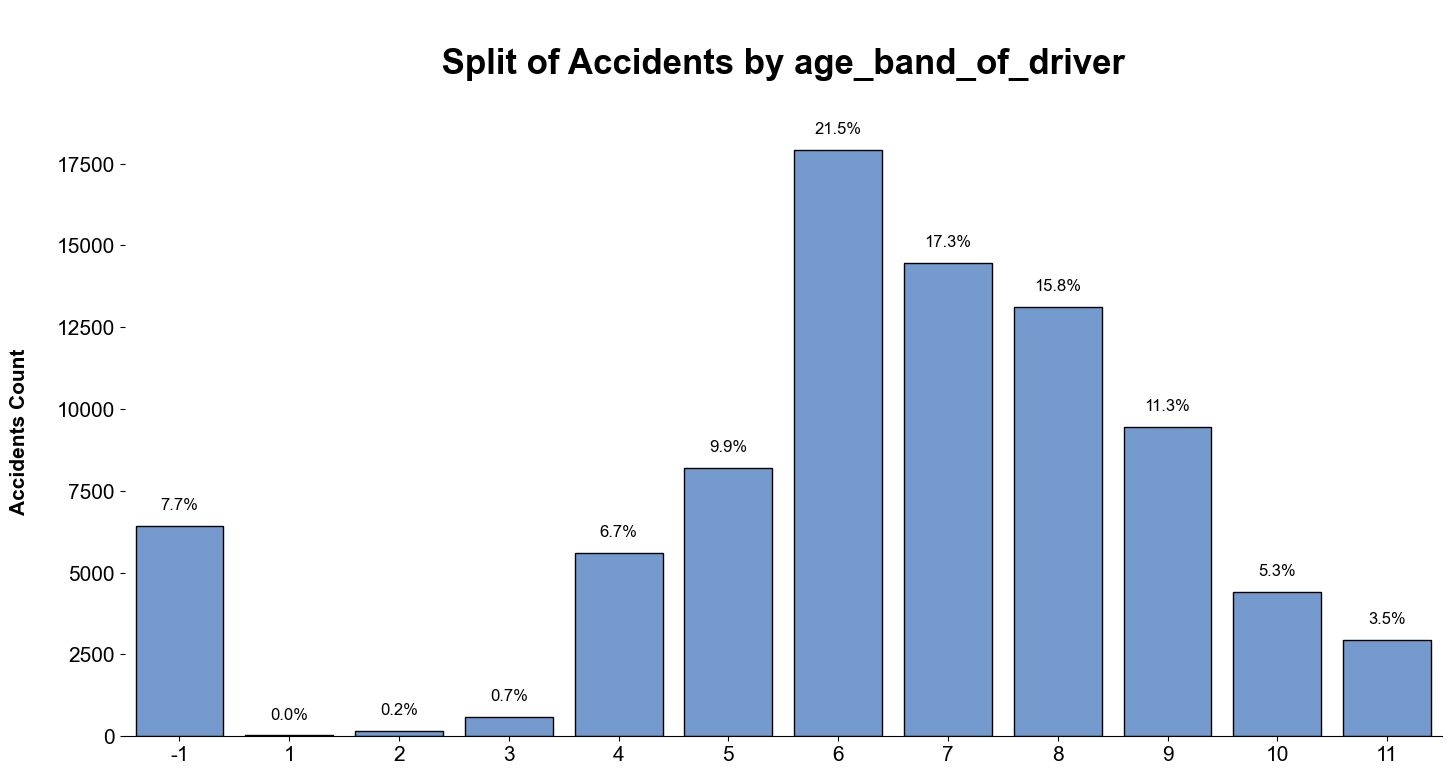

In [49]:
#group accidents by day of the age_band_of_driver
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'age_band_of_driver', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by age_band_of_driver \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

In [50]:
def map_age_to_age_band(age):
    if age >= 1 and age <= 5:
        return 1
    elif age >= 6 and age <= 10:
        return 2
    elif age >= 11 and age <= 15:
        return 3
    elif age >= 16 and age <= 20:
        return 4
    elif age >= 21 and age <= 25:
        return 5
    elif age >= 26 and age <= 35:
        return 6
    elif age >= 36 and age <= 45:
        return 7
    elif age >= 46 and age <= 55:
        return 8
    elif age >= 56 and age <= 65:
        return 9
    elif age >= 66 and age <= 75:
        return 10
    else:
        return 11 

# Apply the function to create a new 'age_band_of_driver' column
a_mining_copy['age_band_of_driver'] = a_mining_copy['age_of_driver'].apply(map_age_to_age_band)


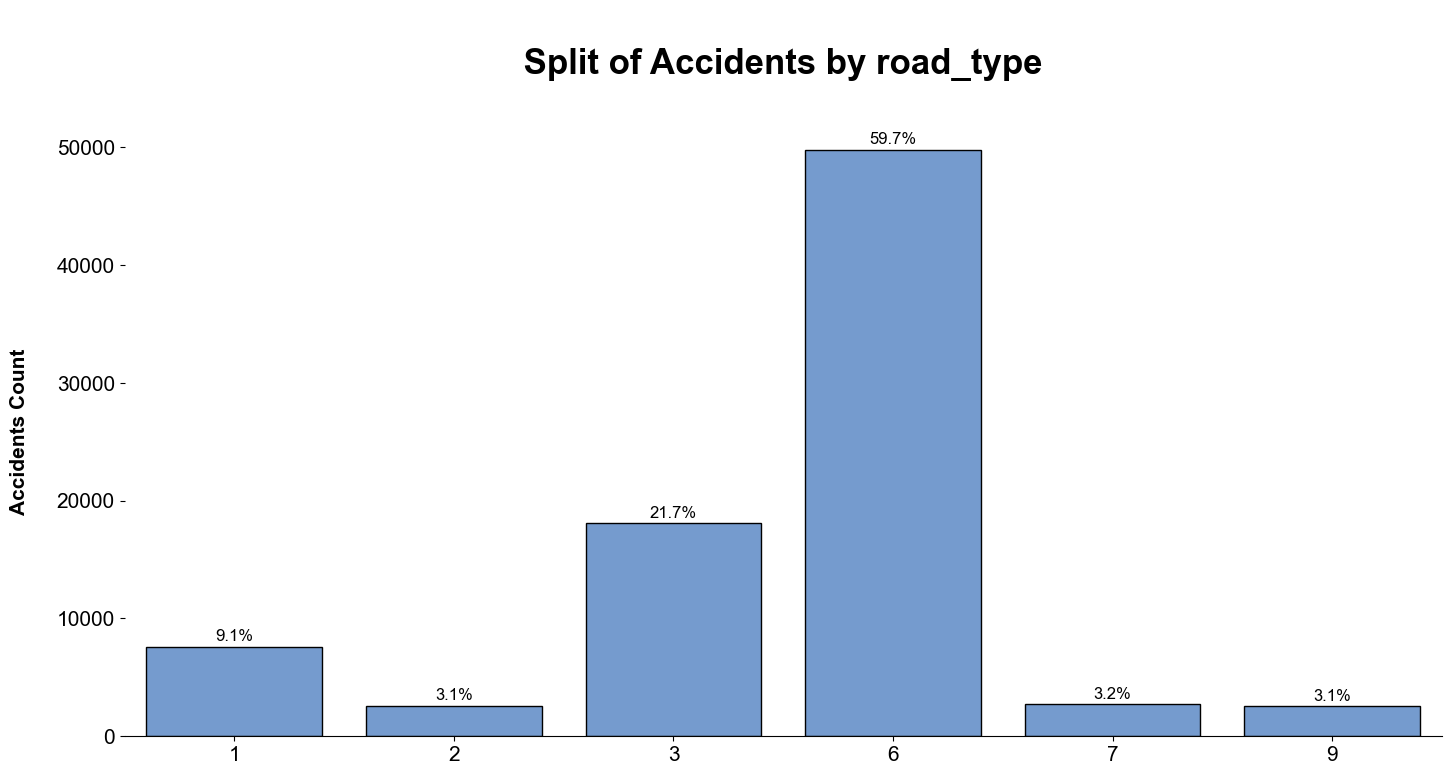

In [51]:
#group accidents by day of the road_type
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'road_type', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by road_type \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

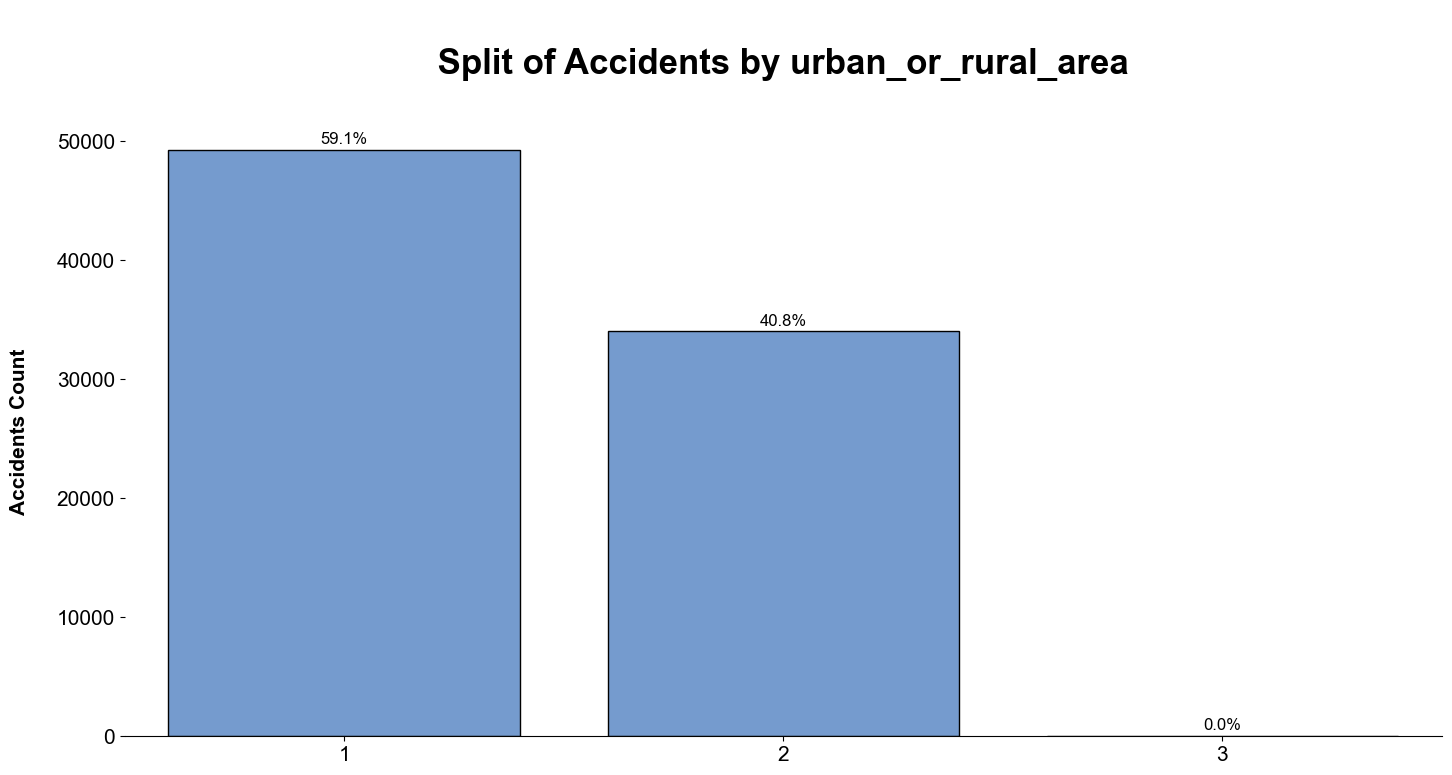

In [52]:
#group accidents by day of the urban_or_rural_area
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'urban_or_rural_area', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by urban_or_rural_area \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

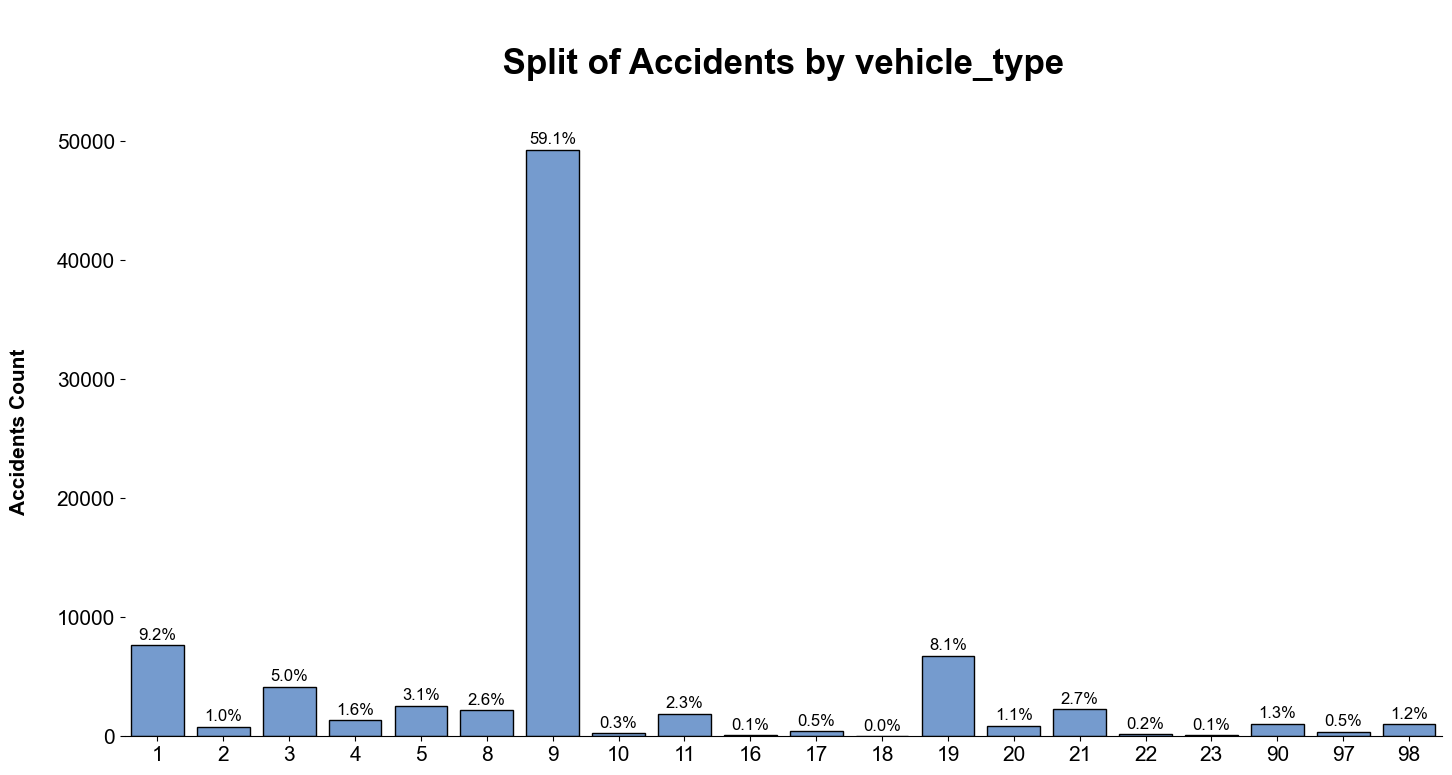

In [53]:
#group accidents by day of the vehicle_type
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'vehicle_type', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by vehicle_type \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

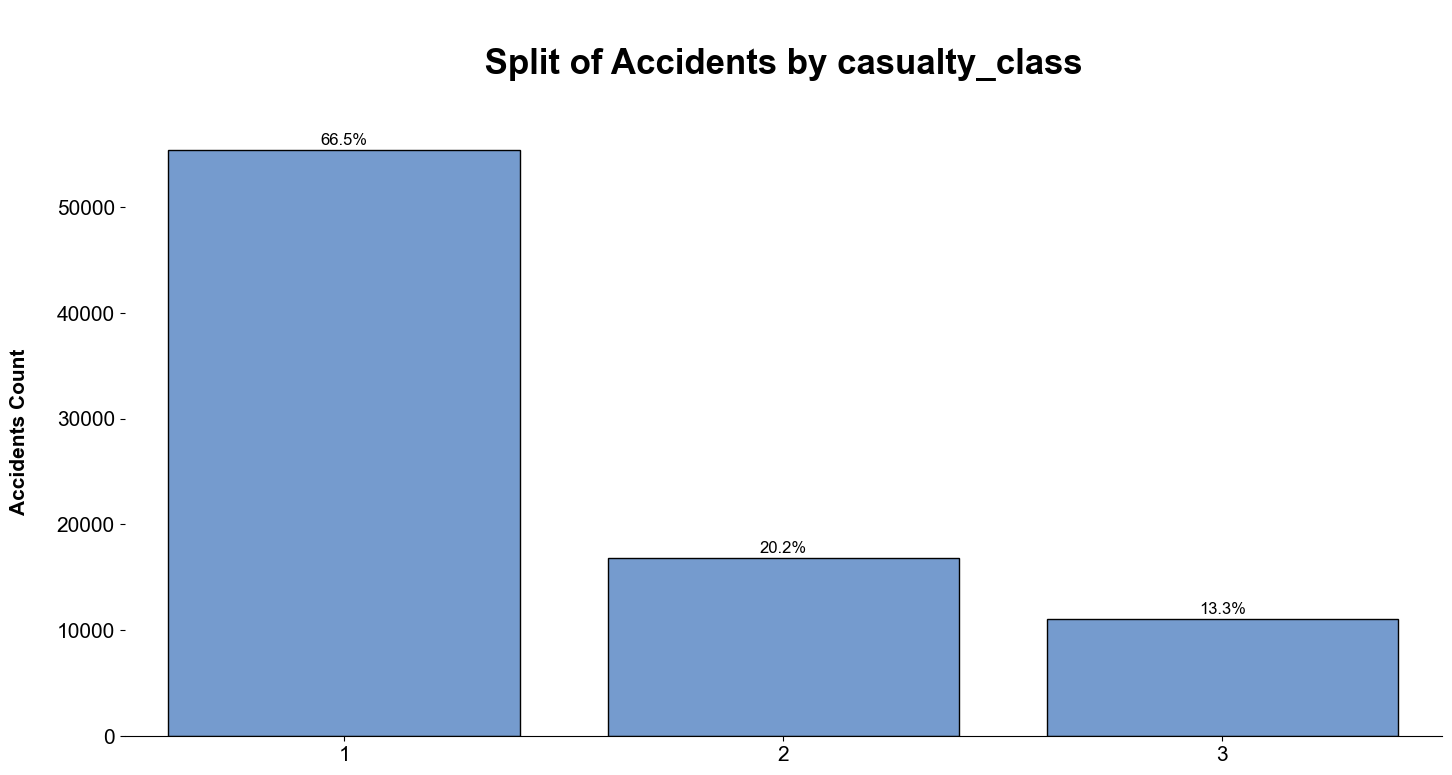

In [54]:
#group accidents by day of the casualty_class
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'casualty_class', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by casualty_class \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

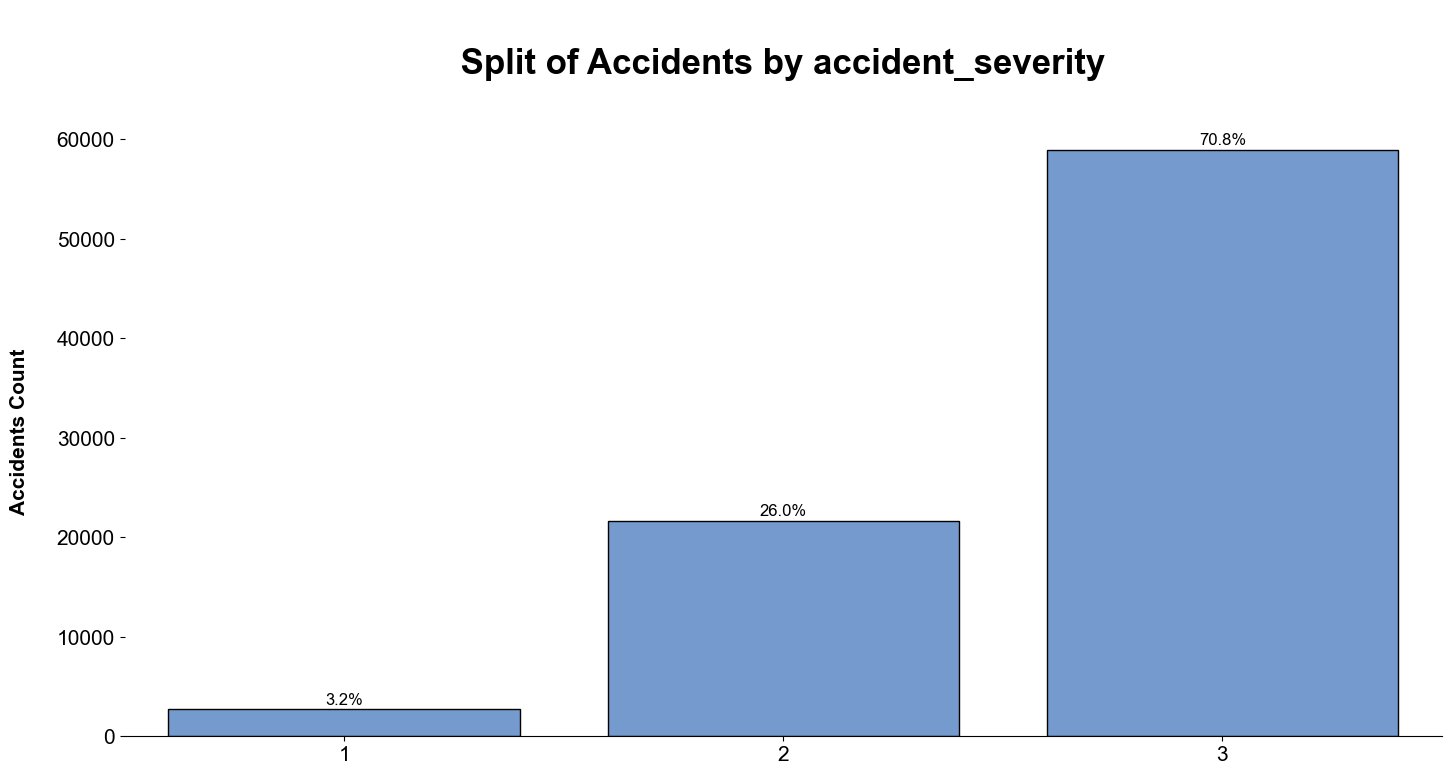

In [55]:
#group accidents by day of the accident_severity
plt.figure(figsize=(17, 8))

#Group accidents by speedlimit
ax = sns.countplot(data = a_mining_copy, x = 'accident_severity', color='#69d', edgecolor='black')
total_accidents = len(a_mining_copy)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_accidents)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + 500), ha='center', fontsize=12, fontname='Arial', color='black')


plt.title('\n Split of Accidents by accident_severity \n',
          fontsize=25, fontweight='bold', fontname='Arial')
plt.xlabel('', fontsize=10, fontweight='bold', fontname='Arial')
plt.ylabel('Accidents Count \n', fontsize=15, fontweight='bold', fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.xticks(fontsize=15, fontname='Arial', rotation=0)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()

In [56]:
a_mining_copy=a_mining_copy.drop(["age_of_driver"], axis=1)

In [57]:
df_severity = a_mining_copy["accident_severity"].apply(lambda x: 1 if x == 1 else 0)

In [58]:
df_severity.value_counts()

0    80606
1     2704
Name: accident_severity, dtype: int64

### Balance the dataset

In [59]:
df_balanced, y_balanced = RandomUnderSampler().fit_resample(a_mining_copy, df_severity)

In [60]:
df_balanced

,accident_severity,speed_limit,weather_conditions,light_conditions,road_type,road_surface_conditions,urban_or_rural_area,vehicle_type,sex_of_driver,age_band_of_driver,pedestrian_movement,casualty_class
0,3,30,1,4,6,2,1,9,1,6,0,2
1,3,60,2,1,6,2,2,9,2,11,0,1
2,3,30,1,6,6,1,2,9,3,11,7,3
3,3,20,1,1,1,1,1,1,1,7,0,1
4,2,60,1,1,6,2,2,21,1,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5403,1,70,1,6,3,2,1,21,1,7,3,3
5404,1,60,1,1,6,2,2,9,1,8,0,1
5405,1,60,1,1,6,2,2,1,1,6,0,1
5406,1,60,8,1,6,4,2,9,2,6,0,1


In [61]:
y_balanced.value_counts()

0    2704
1    2704
Name: accident_severity, dtype: int64

In [62]:
X = df_balanced.drop(["accident_severity"], axis=1)

In [63]:
X_numeric = X.select_dtypes([np.number])
X_numeric

,speed_limit,weather_conditions,light_conditions,road_type,road_surface_conditions,urban_or_rural_area,vehicle_type,sex_of_driver,age_band_of_driver,pedestrian_movement,casualty_class
0,30,1,4,6,2,1,9,1,6,0,2
1,60,2,1,6,2,2,9,2,11,0,1
2,30,1,6,6,1,2,9,3,11,7,3
3,20,1,1,1,1,1,1,1,7,0,1
4,60,1,1,6,2,2,21,1,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5403,70,1,6,3,2,1,21,1,7,3,3
5404,60,1,1,6,2,2,9,1,8,0,1
5405,60,1,1,6,2,2,1,1,6,0,1
5406,60,8,1,6,4,2,9,2,6,0,1


### Feature Selection with SelectKBest

In [64]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X_numeric,y_balanced)

SelectKBest()

In [65]:
mask = selector.get_support()
mask

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True])

In [66]:
# Store the column names before feature selection
feature_names = X_numeric.columns

# Apply SelectKBest with the imputed data
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X_numeric, y_balanced)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Use the indices to retrieve the selected feature names
selected_feature_names = feature_names[selected_indices]

# Print the selected feature names
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['speed_limit', 'weather_conditions', 'light_conditions', 'road_type',
       'road_surface_conditions', 'urban_or_rural_area', 'vehicle_type',
       'sex_of_driver', 'pedestrian_movement', 'casualty_class'],
      dtype='object')


In [67]:
scores = selector.scores_[mask]
scores

array([5.75523490e+02, 8.51565821e+01, 1.93177226e+01, 1.17471450e+02,
       1.98649279e+01, 3.14534023e+02, 4.69770349e-01, 1.30395326e+02,
       1.07878752e+01, 9.09296295e+00])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'speed_limit'),
  Text(1, 0, 'weather_conditions'),
  Text(2, 0, 'light_conditions'),
  Text(3, 0, 'road_type'),
  Text(4, 0, 'road_surface_conditions'),
  Text(5, 0, 'urban_or_rural_area'),
  Text(6, 0, 'vehicle_type'),
  Text(7, 0, 'sex_of_driver'),
  Text(8, 0, 'pedestrian_movement'),
  Text(9, 0, 'casualty_class')])

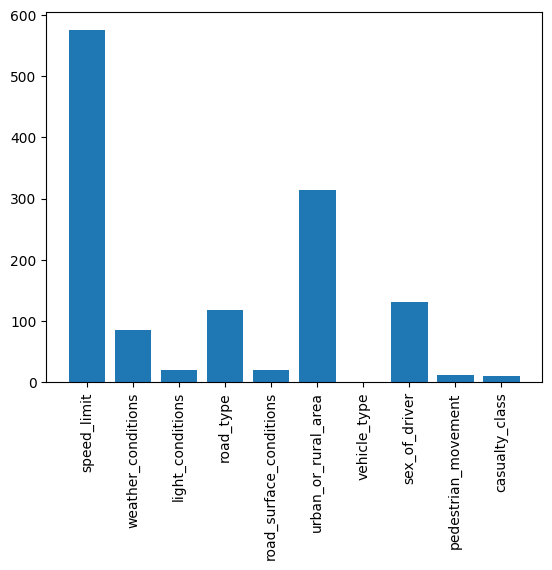

In [68]:
plt.bar(selected_feature_names, scores)
plt.xticks(rotation="vertical")

In [69]:
df_severity_new = df_balanced[["accident_severity","speed_limit", "urban_or_rural_area","light_conditions", "road_type","sex_of_driver","road_surface_conditions","weather_conditions"]]
df_severity_new

,accident_severity,speed_limit,urban_or_rural_area,light_conditions,road_type,sex_of_driver,road_surface_conditions,weather_conditions
0,3,30,1,4,6,1,2,1
1,3,60,2,1,6,2,2,2
2,3,30,2,6,6,3,1,1
3,3,20,1,1,1,1,1,1
4,2,60,2,1,6,1,2,1
...,...,...,...,...,...,...,...,...
5403,1,70,1,6,3,1,2,1
5404,1,60,2,1,6,1,2,1
5405,1,60,2,1,6,1,2,1
5406,1,60,2,1,6,2,4,8


### One hot encode the columns and merge the dataframes

In [70]:
def one_hot_encode(cols, df):
    one_hot_list = []
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)
        one_hot_list.append(dummies)
        
    return pd.concat(one_hot_list, axis=1)

In [71]:
cols = ["accident_severity","speed_limit", "urban_or_rural_area","light_conditions", "road_type","sex_of_driver","road_surface_conditions","weather_conditions"]
df_acc_onehot =  one_hot_encode(cols, df_balanced)
df_acc_onehot

,accident_severity_1,accident_severity_2,accident_severity_3,speed_limit_20,speed_limit_30,speed_limit_40,speed_limit_50,speed_limit_60,speed_limit_70,urban_or_rural_area_1,...,road_surface_conditions_5,weather_conditions_1,weather_conditions_2,weather_conditions_3,weather_conditions_4,weather_conditions_5,weather_conditions_6,weather_conditions_7,weather_conditions_8,weather_conditions_9
0,0,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,1,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
5404,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5405,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5406,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [72]:
frequent_items = apriori(df_acc_onehot, min_support=0.2, use_colnames=True)
frequent_items["length"] = frequent_items["itemsets"].apply(lambda x: len(x))
frequent_items

C:\Users\chime\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,length
0,0.500000,(accident_severity_1),1
1,0.365939,(accident_severity_3),1
2,0.374075,(speed_limit_30),1
3,0.222818,(speed_limit_60),1
4,0.465607,(urban_or_rural_area_1),1
...,...,...,...
105,0.219490,"(weather_conditions_1, road_surface_conditions...",4
106,0.222448,"(weather_conditions_1, light_conditions_1, roa...",4
107,0.246857,"(weather_conditions_1, light_conditions_1, roa...",4
108,0.263314,"(weather_conditions_1, light_conditions_1, roa...",4


### Generating Rules

In [73]:
rule_1 = association_rules(frequent_items, metric="lift", min_threshold=1)
rule_1.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(urban_or_rural_area_2),(accident_severity_1),0.534209,0.500000,0.325814,0.609900,1.219799,0.058709,1.281721,0.386853
1,(accident_severity_1),(urban_or_rural_area_2),0.500000,0.534209,0.325814,0.651627,1.219799,0.058709,1.337049,0.360386
2,(road_type_6),(accident_severity_1),0.667345,0.500000,0.374075,0.560543,1.121086,0.040403,1.137768,0.324684
3,(accident_severity_1),(road_type_6),0.500000,0.667345,0.374075,0.748151,1.121086,0.040403,1.320852,0.216016
4,(sex_of_driver_1),(accident_severity_1),0.721339,0.500000,0.392936,0.544732,1.089464,0.032267,1.098255,0.294686
5,(accident_severity_1),(sex_of_driver_1),0.500000,0.721339,0.392936,0.785873,1.089464,0.032267,1.301382,0.164235
6,(road_surface_conditions_1),(accident_severity_1),0.594490,0.500000,0.312870,0.526283,1.052566,0.015625,1.055483,0.123156
7,(accident_severity_1),(road_surface_conditions_1),0.500000,0.594490,0.312870,0.625740,1.052566,0.015625,1.083498,0.099882
8,(weather_conditions_1),(accident_severity_1),0.720414,0.500000,0.391642,0.543634,1.087269,0.031435,1.095613,0.287083
9,(accident_severity_1),(weather_conditions_1),0.500000,0.720414,0.391642,0.783284,1.087269,0.031435,1.290102,0.160529


In [74]:
# get the association rules in a dataframe

rule_2 = association_rules(frequent_items, metric="confidence", min_threshold=0.7)
rule_2.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(accident_severity_1),(road_type_6),0.500000,0.667345,0.374075,0.748151,1.121086,0.040403,1.320852,0.216016
1,(accident_severity_1),(sex_of_driver_1),0.500000,0.721339,0.392936,0.785873,1.089464,0.032267,1.301382,0.164235
2,(accident_severity_1),(weather_conditions_1),0.500000,0.720414,0.391642,0.783284,1.087269,0.031435,1.290102,0.160529
3,(speed_limit_30),(urban_or_rural_area_1),0.374075,0.465607,0.295673,0.790410,1.697593,0.121501,2.549712,0.656518
4,(speed_limit_30),(road_type_6),0.374075,0.667345,0.279401,0.746911,1.119228,0.029764,1.314378,0.170191
5,(speed_limit_30),(sex_of_driver_1),0.374075,0.721339,0.262574,0.701928,0.973090,-0.007261,0.934878,-0.042311
6,(speed_limit_60),(urban_or_rural_area_2),0.222818,0.534209,0.217086,0.974274,1.823771,0.098054,18.105763,0.581184
7,(urban_or_rural_area_1),(weather_conditions_1),0.465607,0.720414,0.326553,0.701350,0.973538,-0.008876,0.936166,-0.048403
8,(urban_or_rural_area_2),(sex_of_driver_1),0.534209,0.721339,0.396265,0.741779,1.028337,0.010919,1.079159,0.059159
9,(urban_or_rural_area_2),(weather_conditions_1),0.534209,0.720414,0.393676,0.736933,1.022930,0.008825,1.062794,0.048124


In [75]:
# Extract the top rule from rule_1
top_rule_1 = rule_1.iloc[0]

# Extract the antecedent and consequent items
antecedent = list(top_rule_1['antecedents'])
consequent = list(top_rule_1['consequents'])

# Interpret the rule in the context of accidents in 2020
print("Association Rule Analysis for Accidents in 2020")
print("----------------------------------------------------")
print("If there was an accident involving:")
print(", ".join(antecedent))  # Join the items in the list
print("Then there is a likelihood of an accident involving:")
print(", ".join(consequent))
print("Key Metrics:")
print(f"Support: {top_rule_1['support']:.4f} (Percentage of accidents involving {', '.join(antecedent)})")
print(f"Confidence: {top_rule_1['confidence']:.4f} (Conditional probability of accidents involving {', '.join(consequent)} given {', '.join(antecedent)})")
print(f"Lift: {top_rule_1['lift']:.4f} (Strength of association between accidents involving {', '.join(antecedent)} and {', '.join(consequent)})")


Association Rule Analysis for Accidents in 2020
----------------------------------------------------
If there was an accident involving:
urban_or_rural_area_2
Then there is a likelihood of an accident involving:
accident_severity_1
Key Metrics:
Support: 0.3258 (Percentage of accidents involving urban_or_rural_area_2)
Confidence: 0.6099 (Conditional probability of accidents involving accident_severity_1 given urban_or_rural_area_2)
Lift: 1.2198 (Strength of association between accidents involving urban_or_rural_area_2 and accident_severity_1)


## Clustering 
### Identify accidents in our region: Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc. You can do this by filtering on LSOA, or police region or another method if you can find one. Run clustering on this data. What do these clusters reveal about the distribution of accidents in our region?

In [76]:
clustering_df = pd.read_sql_query("""
    SELECT  accident_index, longitude, latitude
    FROM accident 
    WHERE accident_year = 2020 and police_force = 16
 """, con)

clustering_df.head()

,accident_index,longitude,latitude
0,2020160914781,-0.331047,53.747751
1,2020160914930,-0.393424,53.744936
2,2020160915008,-0.528743,53.512895
3,2020160915028,-0.324858,53.791630
4,2020160915041,-0.095008,53.574501


In [77]:
# cluster for geographical data 
geo_df = clustering_df[['longitude', 'latitude']]
geo_df

,longitude,latitude
0,-0.331047,53.747751
1,-0.393424,53.744936
2,-0.528743,53.512895
3,-0.324858,53.791630
4,-0.095008,53.574501
...,...,...
1704,-0.651104,53.566753
1705,-0.424674,53.839482
1706,-0.308880,53.782750
1707,-0.703181,53.569801


In [78]:
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1709 entries, 0 to 1708
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  1709 non-null   float64
 1   latitude   1709 non-null   float64
dtypes: float64(2)
memory usage: 26.8 KB


In [79]:
geo_df.isnull().sum()

longitude    0
latitude     0
dtype: int64

C:\Users\chime\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chime\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
C:\Users\chime\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chime\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

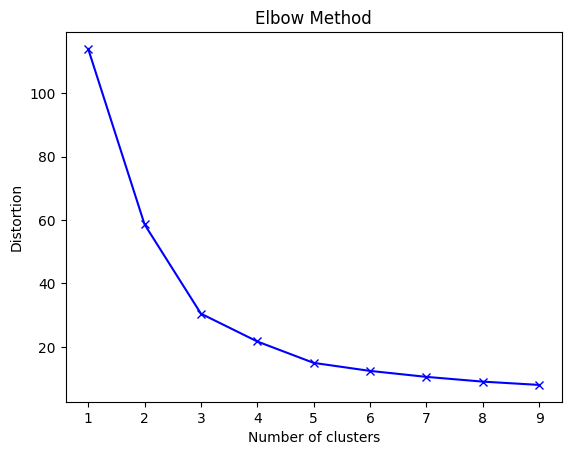

In [80]:
#This is used to determine the number of clusters

distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(geo_df)
    distortions.append(kmeans.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [81]:
# Assuming you have already defined reg_df

# reg_df should be a DataFrame containing your data points with columns 'longitude' and 'latitude'

# Define the number of clusters

n_clusters = 3

 

# Initialize and fit the KMedoids model

kmedoids = KMedoids(n_clusters=n_clusters, random_state=0)

kmedoids.fit(geo_df)

 

# Get cluster labels and cluster centers

label2 = kmedoids.predict(geo_df)

centroid2 = kmedoids.cluster_centers_

 

# Create a colormap with 10 different colors (one for each cluster)

colormap = plt.cm.get_cmap('tab10', n_clusters)

 

# Create a folium map centered around Humberside

humberside_coords = (53.73130, -0.43745)

humberside_map = folium.Map(location=humberside_coords, zoom_start=10)

 

# Add markers for each cluster center

for i, centroid in enumerate(centroid2):

    folium.Marker(location=[centroid[1], centroid[0]], popup=f"Cluster {i+1} Center", icon=folium.Icon(color='red')).add_to(humberside_map)


# Add scatter plot points for the data points with colors representing their clusters

for lon, lat, cluster_label in zip(geo_df['longitude'], geo_df['latitude'], label2):

    color = colormap(cluster_label)

    folium.CircleMarker(location=[lat, lon], radius=5, color=None, fill_color=color, fill_opacity=0.7).add_to(humberside_map)

# Display the map

humberside_map.save("humberside_cluster_map.html")  # Save the map as an HTML file

 

humberside_map

In [82]:
labels = kmeans.predict(geo_df)
centroids = kmeans.cluster_centers_

centroids

array([[-0.08648334, 53.56976652],
       [-0.59757064, 53.763276  ],
       [-0.29410963, 53.76560506],
       [-0.8688132 , 53.66163051],
       [-0.21076085, 54.06648145],
       [-0.38594898, 53.73983036],
       [-0.80005007, 53.91477038],
       [-0.4485531 , 53.90876687],
       [-0.62988773, 53.57302652]])

In [83]:
labels

array([2, 5, 8, ..., 2, 8, 5])

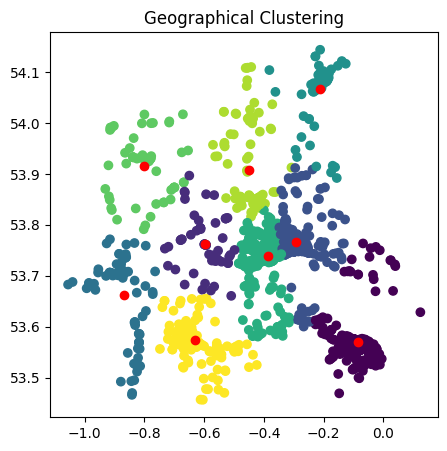

In [84]:
# Plot k-means clustering for the geo_df

fig = plt.figure(figsize=(5,5))
plt.scatter(geo_df["longitude"], geo_df["latitude"], c=labels)
plt.scatter(centroids[:,0], centroids[:,1], color="red")
plt.title("Geographical Clustering")
plt.show()

In [85]:
kmeans= KMeans(n_clusters=3)
kmeans.fit(geo_df)
kmeans.inertia_

C:\Users\chime\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chime\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


30.49093665140814

In [86]:
labels = kmeans.predict(geo_df)
centroids = kmeans.cluster_centers_

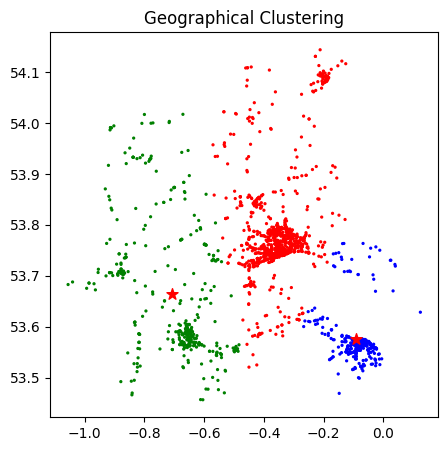

In [87]:
fig = plt.figure(figsize=(5,5))
colmap = {1:"r", 2:"g", 3:"b"}
colors = list(map(lambda x: colmap[x+1], labels))

plt.title("Geographical Clustering")
plt.scatter(geo_df["longitude"], geo_df["latitude"], s=7 , marker='.', color=colors)

plt.scatter(centroids[:,0], centroids[:,1], s=70 , marker='*', color="red")
plt.show()

### Clustering Evaluation

In [88]:
# Calculate Silhouette Score
# Number of clusters
n_clusters = 3

# Create K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model and predict cluster labels
cluster_labels = kmeans.fit_predict(geo_df)

silhouette_avg = silhouette_score(geo_df, labels)
print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.2f}")

C:\Users\chime\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chime\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


Silhouette Score for 3 clusters: 0.59


In [89]:
# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(geo_df, labels)
print(f"Davies-Bouldin Index for {n_clusters} clusters: {davies_bouldin:.2f}")

Davies-Bouldin Index for 3 clusters: 0.61


## Outlier Detection
### Using outlier detection methods, identify unusual entries in your data set. Should you keep these entries in your data? 

In [90]:
# Apply Isolation Forest for outlier detection
ranst = np.random.RandomState(0)
model = IsolationForest(max_samples=100, random_state=ranst, contamination=0.05)

outlier_detect = pd.read_sql_query("""
    SELECT accident_index,latitude, longitude FROM accident WHERE accident_year = 2020
""", con)

outlier_detect.head()
X = outlier_detect[['latitude', 'longitude']]
X = X.fillna(X.mean())
model.fit(X)

if_scores = model.decision_function(X)
if_anomalies = model.predict(X)
if_anomalies = pd.Series(if_anomalies).replace([-1, 1], [1, 0])
if_anomalies = outlier_detect[if_anomalies == 1]

# Apply Local Outlier Factor for outlier detection
lof = LocalOutlierFactor(contamination=0.05)
lof_scores = lof.fit_predict(X)
lof_threshold = quantile(lof_scores, 0.05)
lof_anomalies = where(lof_scores <= lof_threshold)[0]

# Combine outlier indices from both methods
combined_outliers = np.union1d(if_anomalies.index, lof_anomalies)

# Print the indices of detected outliers
print("Indices of detected outliers:", combined_outliers)


C:\Users\chime\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Indices of detected outliers: [   12    36    42 ... 91196 91197 91198]


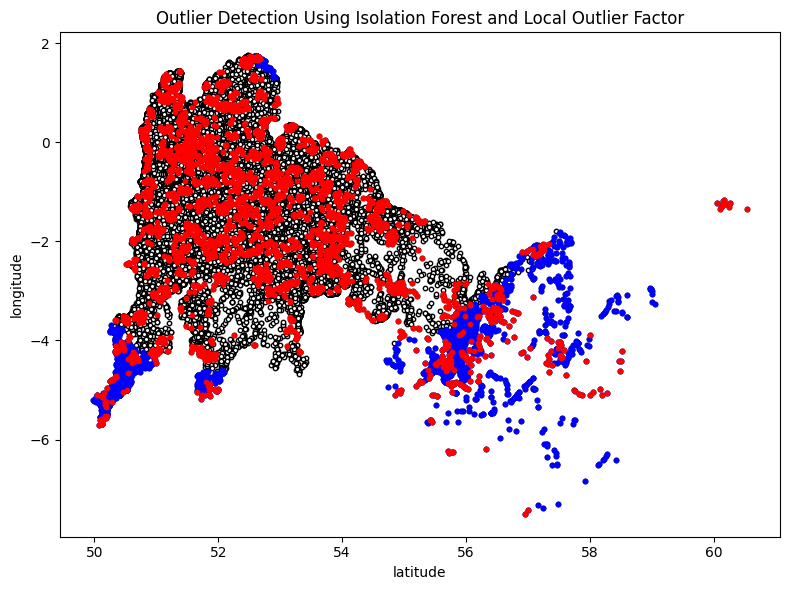

In [91]:
# Plot original data with Isolation Forest and LOF anomalies highlighted
plt.figure(figsize=(8, 6))  # Adjust the figsize as needed

# Reduce the size of the dots by adjusting the 's' parameter
dot_size = 10  # Adjust this value to your preference

plt.scatter(outlier_detect['latitude'], outlier_detect['longitude'], c='white', s=dot_size, edgecolor='k')
plt.scatter(if_anomalies['latitude'], if_anomalies['longitude'], c='blue', s=dot_size)
plt.scatter(outlier_detect.loc[lof_anomalies, 'latitude'], outlier_detect.loc[lof_anomalies, 'longitude'], c='red', s=dot_size)
plt.xlabel("latitude")
plt.ylabel("longitude")
# Remove grid lines
plt.grid(False)
plt.title("Outlier Detection Using Isolation Forest and Local Outlier Factor")
plt.tight_layout()
plt.show()

# Classification Model
### Can you develop a classification model using the provided data that accurately predicts fatal injuries sustained in road traffic accidents, with the aim of informing and improving road safety measures?

#### Target Column

In [92]:
#Using the balanced and cleaned data from association mining
df_severity.value_counts() # fatal =1 non-fatal=0

0    80606
1     2704
Name: accident_severity, dtype: int64

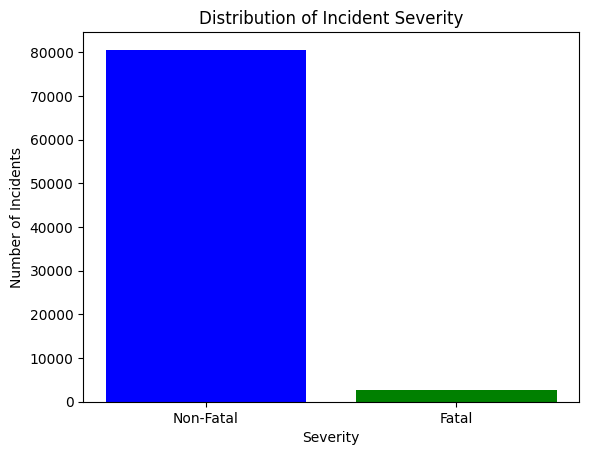

In [93]:
# Count the occurrences of each severity level
severity_counts = df_severity.value_counts()

# Create a bar plot
plt.bar(severity_counts.index, severity_counts.values, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Severity')
plt.ylabel('Number of Incidents')
plt.title('Distribution of Incident Severity')

# Customize x-axis ticks
plt.xticks(severity_counts.index, ['Non-Fatal', 'Fatal'])

# Show the plot
plt.show()



#### Independent Variables

In [94]:
df_model = a_mining_copy.copy()

In [95]:
df_model.columns

Index(['accident_severity', 'speed_limit', 'weather_conditions',
       'light_conditions', 'road_type', 'road_surface_conditions',
       'urban_or_rural_area', 'vehicle_type', 'sex_of_driver',
       'age_band_of_driver', 'pedestrian_movement', 'casualty_class'],
      dtype='object')

In [96]:
X = df_model.drop("accident_severity",axis=1)
y = df_severity

In [97]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83310 entries, 0 to 220429
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   speed_limit              83310 non-null  int64
 1   weather_conditions       83310 non-null  int64
 2   light_conditions         83310 non-null  int64
 3   road_type                83310 non-null  int64
 4   road_surface_conditions  83310 non-null  int64
 5   urban_or_rural_area      83310 non-null  int64
 6   vehicle_type             83310 non-null  int64
 7   sex_of_driver            83310 non-null  int64
 8   age_band_of_driver       83310 non-null  int64
 9   pedestrian_movement      83310 non-null  int64
 10  casualty_class           83310 non-null  int64
dtypes: int64(11)
memory usage: 7.6 MB


In [98]:
cols = ['accident_severity', 'speed_limit', 'weather_conditions',
       'light_conditions', 'road_type', 'road_surface_conditions',
       'urban_or_rural_area', 'vehicle_type', 'sex_of_driver',
       'age_band_of_driver', 'pedestrian_movement', 'casualty_class']
d_onehot =  one_hot_encode(cols, df_model)
d_onehot

,accident_severity_1,accident_severity_2,accident_severity_3,speed_limit_20,speed_limit_30,speed_limit_40,speed_limit_50,speed_limit_60,speed_limit_70,weather_conditions_1,...,pedestrian_movement_3,pedestrian_movement_4,pedestrian_movement_5,pedestrian_movement_6,pedestrian_movement_7,pedestrian_movement_8,pedestrian_movement_9,casualty_class_1,casualty_class_2,casualty_class_3
0,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220411,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
220418,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
220419,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
220426,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


### Applying SMOTE for imbalanced data

In [99]:
sm = SMOTE(random_state=20, k_neighbors = 2) # The object is created
# apply SMOTE to resample the dataset
X_res, y_res = sm.fit_resample(X, y) # The object is applied
X, y = X_res, y_res # reassigning the balanced dataset to X,y


### Train Test spilt

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (128969, 11)
X_test shape: (32243, 11)
Y_train shape: (128969,)
Y_test shape: (32243,)


### Model Selection

In [102]:
# Define the base classifier
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100,random_state=20)

# Define the ensemble
ensemble = VotingClassifier(estimators=[('dt', dt), ('knn', knn), ('rf',rf)])
#Hard voting entails picking the prediction with the highest number of votes



### Model Evaluation

In [103]:
def classifier(model,X_train, y_train, X_test,y_test, random_state=20):
    # Fit the classifier on the training data
    model.fit(X_train, y_train)
 
    # Predict target values for test data
    y_pred = model.predict(X_test)
 
    # Calculate accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    f1 = f1_score(y_test, y_pred,average=None).mean()
    
    precision = precision_score(y_test, y_pred,average=None).mean()
    
    recall= recall_score(y_test, y_pred,average=None).mean()
    
    
    print(f"F1 score:{f1:.3f}")
 
    # Print accuracy of the model
    print(f"Accuracy: {accuracy:.3f}")
 
    # Print accuracy of the model
    print(f"precision: {precision:.3f}")
    
    # Print accuracy of the model
    print(f"recall: {recall:.3f}")
    
    # Print classification report and confusion matrix
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print('-' * 50)
 

### checking for overfitting with cross validation

In [104]:
def cross_validate(model, X, y, cv=5, random_state = 20):
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv = cv)
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()
    # Print mean and standard deviation of scores
    print(f'Cross-validation scores: {cv_scores}')
    print('-' * 50)
    print(f'Mean score: {mean_score:.3f}, Std score: {std_score:.3f}') 
    print('-' * 50)
    print('Accuracy: %0.2f (+/- %0.2f)' % (mean_score, std_score * 2))


### Decision Trees

In [105]:
classifier(dt, X_train, Y_train, X_test, Y_test)

F1 score:0.912
Accuracy: 0.913
precision: 0.920
recall: 0.912
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     16037
           1       0.87      0.98      0.92     16206

    accuracy                           0.91     32243
   macro avg       0.92      0.91      0.91     32243
weighted avg       0.92      0.91      0.91     32243

--------------------------------------------------


In [117]:
 cross_validate(dt, X, y, cv=5, random_state = 20)

Cross-validation scores: [0.89287597 0.91387278 0.89780411 0.9064264  0.92612121]
--------------------------------------------------
Mean score: 0.907, Std score: 0.012
--------------------------------------------------
Accuracy: 0.91 (+/- 0.02)


### KNearest Neighbors

In [106]:
classifier(knn, X_train, Y_train, X_test, Y_test)

F1 score:0.885
Accuracy: 0.886
precision: 0.893
recall: 0.885
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     16037
           1       0.84      0.95      0.89     16206

    accuracy                           0.89     32243
   macro avg       0.89      0.89      0.89     32243
weighted avg       0.89      0.89      0.89     32243

--------------------------------------------------


In [118]:
 cross_validate(knn, X, y, cv=5, random_state = 20)

Cross-validation scores: [0.63195112 0.64193778 0.63966255 0.63234291 0.63665405]
--------------------------------------------------
Mean score: 0.637, Std score: 0.004
--------------------------------------------------
Accuracy: 0.64 (+/- 0.01)


### Random Forest 

In [107]:
classifier(rf, X_train, Y_train, X_test, Y_test)

F1 score:0.917
Accuracy: 0.917
precision: 0.924
recall: 0.917
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     16037
           1       0.87      0.98      0.92     16206

    accuracy                           0.92     32243
   macro avg       0.92      0.92      0.92     32243
weighted avg       0.92      0.92      0.92     32243

--------------------------------------------------


In [119]:
 cross_validate(rf, X, y, cv=5, random_state = 20)

Cross-validation scores: [0.89594641 0.91858698 0.90468954 0.9126605  0.93303765]
--------------------------------------------------
Mean score: 0.913, Std score: 0.013
--------------------------------------------------
Accuracy: 0.91 (+/- 0.03)


### Voting Ensemble

In [108]:

classifier(ensemble, X_train, Y_train, X_test, Y_test)

F1 score:0.915
Accuracy: 0.916
precision: 0.922
recall: 0.915
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     16037
           1       0.87      0.98      0.92     16206

    accuracy                           0.92     32243
   macro avg       0.92      0.92      0.92     32243
weighted avg       0.92      0.92      0.92     32243

--------------------------------------------------


In [120]:
 cross_validate(ensemble, X, y, cv=5, random_state = 20)

Cross-validation scores: [0.89622554 0.91821481 0.90431735 0.91231934 0.93238633]
--------------------------------------------------
Mean score: 0.913, Std score: 0.012
--------------------------------------------------
Accuracy: 0.91 (+/- 0.02)


In [109]:
# Sample data (replace with your actual data)
classifiers = [ "dt", "knn","rf","voting"]
performance_values = [[ 0.913, 0.886, 0.917,0.917], [ 0.920, 0.893, 0.924,0.922], [0.913, 0.885, 0.917,0.916]]
metric_name = 'Accuracy'

# Create a dictionary for the DataFrame
data = {'Classifier': classifiers}
data.update(zip([f'{metric_name} {i+1}' for i in range(len(performance_values))], performance_values))

# Create the DataFrame
whisker_df = pd.DataFrame(data)

print(whisker_df)


  Classifier  Accuracy 1  Accuracy 2  Accuracy 3
0         dt       0.913       0.920       0.913
1        knn       0.886       0.893       0.885
2         rf       0.917       0.924       0.917
3     voting       0.917       0.922       0.916


In [110]:
# Set "Classifier" column as the index
whisker_df.set_index('Classifier', inplace=True)

# Transpose the DataFrame
whisker_df_transposed = whisker_df.T

whisker_df_transposed

Classifier,dt,knn,rf,voting
Accuracy 1,0.913,0.886,0.917,0.917
Accuracy 2,0.920,0.893,0.924,0.922
Accuracy 3,0.913,0.885,0.917,0.916


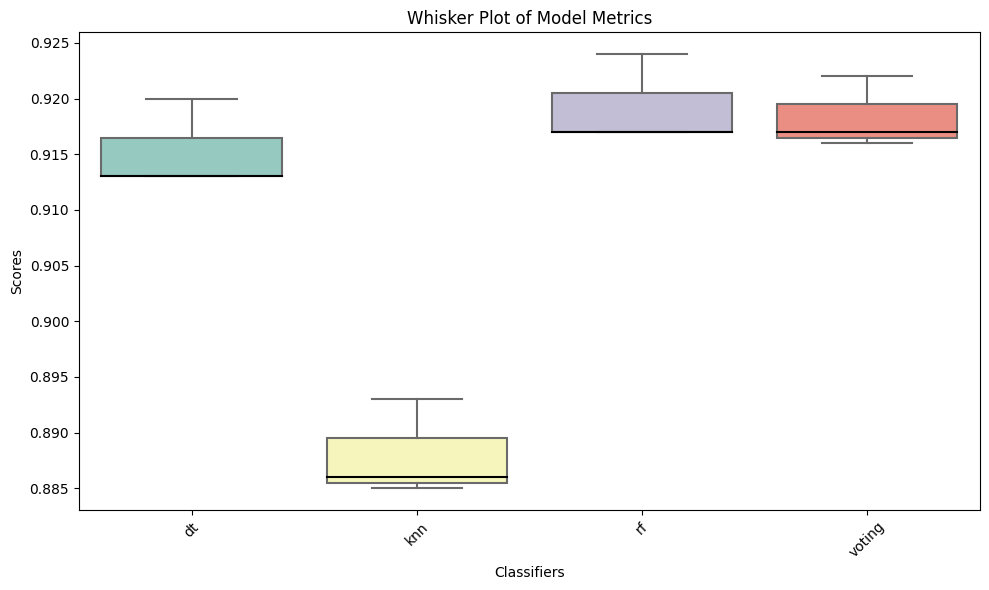

In [111]:
# Plotting using seaborn
plt.figure(figsize=(10, 6))
# Remove grid lines
plt.grid(False)
sns.boxplot(data=whisker_df_transposed, palette="Set3",medianprops=dict(color='black'))
plt.title("Whisker Plot of Model Metrics")
plt.xlabel('Classifiers')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Hyperparameter Tuning on the high performing classifier (Random Forest)

In [112]:

# Define the parameter grid
rf_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,random_state=20)

# Initialize RandomizedSearchCV
rf_random_search = RandomizedSearchCV(rf, param_distributions=rf_param_dist, scoring='accuracy', cv=5, n_iter=10, random_state=20)

# Perform RandomizedSearchCV
rf_random_search.fit(X_train, Y_train)

# Print the best parameters and accuracy
print(f"Best Hyperparameters: {rf_random_search.best_params_}")
print(f"Best Accuracy: {rf_random_search.best_score_}\n")

Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best Accuracy: 0.9148322656675527



## Feature Importance 

In [113]:

# Calculate feature importances for the Random Forest classifier
rf = RandomForestClassifier()  # Replace with your trained Random Forest classifier
rf.fit(X_train, Y_train)  # Make sure you have the training data

feature_importance = pd.Series(
    rf.feature_importances_,
    index=rf.feature_names_in_)


In [114]:
feature_importance

speed_limit                0.155019
weather_conditions         0.095634
light_conditions           0.092464
road_type                  0.114884
road_surface_conditions    0.052814
urban_or_rural_area        0.044831
vehicle_type               0.149424
sex_of_driver              0.062475
age_band_of_driver         0.159073
pedestrian_movement        0.039285
casualty_class             0.034098
dtype: float64

In [115]:
feature_importance.sort_values(ascending=False,
                              inplace=True)

Text(0, 0.5, 'Features')

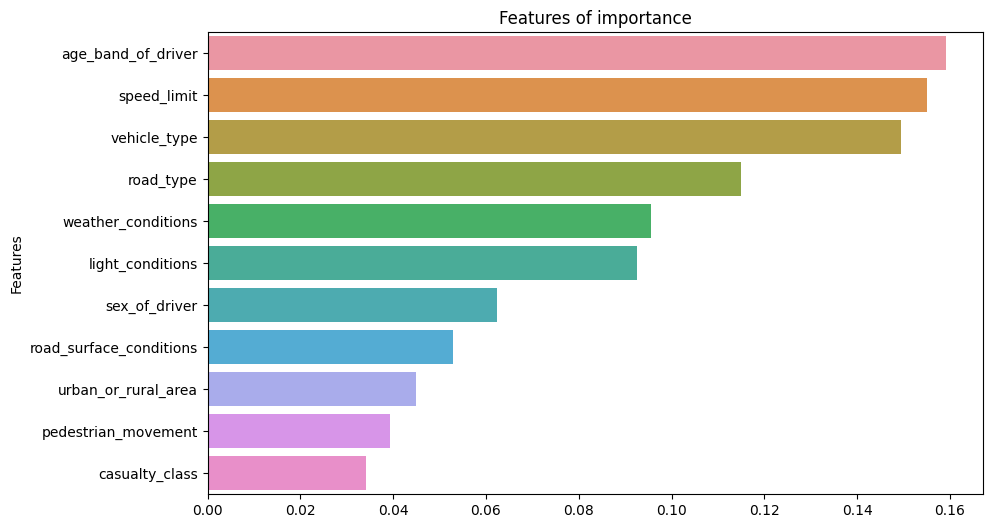

In [116]:
plt.figure(figsize=(10,6))
# Remove grid lines
plt.grid(False)
sns.barplot(x=feature_importance,
           y=feature_importance.index)
plt.title("Features of importance")
plt.ylabel("Features")